# Trying out only the fine alignment step

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps_ai
import aps_ai.beamline34IDC.optimization.common as opt_common
import aps_ai.beamline34IDC.optimization.configs as configs
import aps_ai.beamline34IDC.optimization.movers as movers
import IPython
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from aps_ai.beamline34IDC.facade.focusing_optics_factory import ExecutionMode, focusing_optics_factory_method
from aps_ai.beamline34IDC.facade.focusing_optics_interface import AngularUnits, DistanceUnits, Movement
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement, get_default_input_features
from aps_ai.common.util import clean_up
from aps_ai.common.util.shadow.common import (
    EmptyBeamException,
    PreProcessorFiles,
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from aps_ai.common.util.wrappers import PlotMode
from Shadow.ShadowTools import focnew
from skopt.callbacks import DeadlineStopper, DeltaXStopper, DeltaYStopper
from test_optuna_qnehvi import BoTorchSampler, qnehvi_candidates_func
from tqdm import tqdm

%matplotlib inline

Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2415, in magic
    return self.run_line_magic(magic_name, magic_arg_s, _stack_depth=2)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

Qt5Agg: unable to import specified backend (or its dependency); no plots


In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

41872


In [4]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test


In [5]:
root_dir = Path(aps_ai.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'34-ID'
temp_work_dir = base_dir / f'tmp_work_dir_34-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [6]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [7]:
os.chdir(temp_work_dir)

In [8]:
input_beam_path = "primary_optics_system_beam.dat"

In [12]:
move_motors_ranges = {'hkb_1': [-5, 5], 
                      'vkb_1': [-5, 5],
                      'hkb_2': [-5, 5],
                      'vkb_2': [-5, 5],
                      'hkb_3': [-0.01, 0.01],
                      'vkb_3': [-0.01, 0.01],
                      'hkb_4': [-5, 5], 
                      'vkb_4': [-5, 5]}

In [13]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872

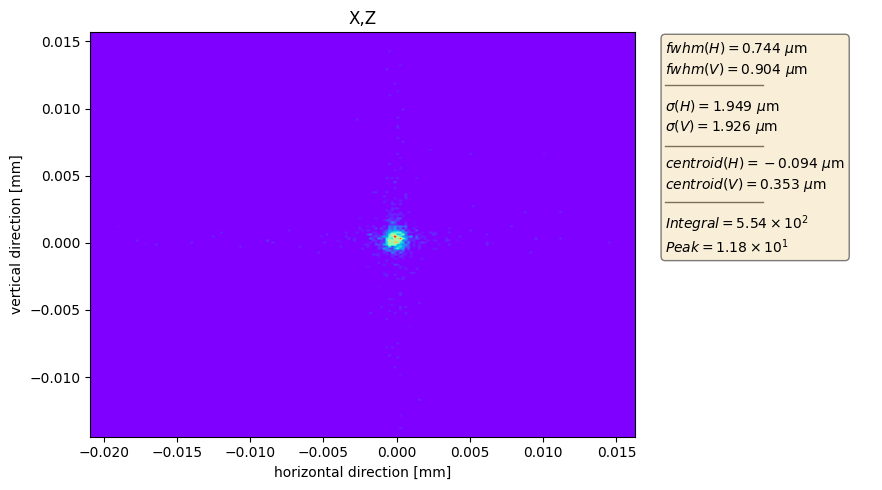

In [14]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
plot_shadow_beam_spatial_distribution(focusing_system.get_photon_beam())

In [15]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [16]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [17]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [114]:
np.round(np.pi, 5)

3.14159

In [115]:
(3 * np.pi ) // 3

3.0

In [124]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    opt_platform = "optuna"

    def set_optimizer_options(
        self,
        motor_ranges: list = None,
        base_sampler: optuna.samplers.BaseSampler = None,
        directions: str = None,
        integral_threshold: float = 1e2,
        raise_prune_exception: bool = True,
        use_discrete_space: bool = True,
        **extra_options
    ):

        self.motor_ranges = self._get_guess_ranges(motor_ranges)

        if base_sampler is None:
            # if self.multi_objective_optimization:
            #    base_sampler = optuna.samplers.MOTPESampler()
            # else:
            base_sampler = optuna.samplers.TPESampler()
        self._base_sampler = base_sampler
        self._raise_prune_exception = raise_prune_exception

        if directions is None:
            directions = ["minimize"] * len(self._loss_function_list)
        elif len(directions) != len(self._loss_function_list):
            raise ValueError
        self._directions = directions

        self.study = optuna.create_study(sampler=self._base_sampler, directions=self._directions)
        self.study.enqueue_trial({mt: 0.0 for mt in self.motor_types})

        loss_fn_obj = self.TrialInstanceLossFunction(self, verbose=False)
        self._loss_fn_this = loss_fn_obj.loss
        self.integral_threshold = integral_threshold
        self._use_discrete_space = use_discrete_space

        self.best_params = {k: 0.0 for k in self.motor_types}

    def _objective(self, trial, step_scale: float = 1):
        current_params = []
        for mot, r in zip(self.motor_types, self.motor_ranges):
            if self._use_discrete_space:
                resolution = np.round(configs.DEFAULT_MOTOR_RESOLUTIONS[mot], 5)
                r_low = np.round(r[0], 5)
                r_high = ((r[1] - r[0]) // resolution) * resolution + r_low
                current_params.append(trial.suggest_float(mot, r_low, r_high, step=resolution * step_scale))
            else:
                current_params.append(trial.suggest_float(mot, r[0], r[1]))
        loss = self._loss_fn_this(current_params)
        if self.multi_objective_optimization:
            if np.nan in loss and self._raise_prune_exception:
                raise optuna.TrialPruned
            loss[np.isnan(loss)] = 1e4

            if self.integral_threshold is not None:
                if self.beam_state.hist.data_2D.sum() < self.integral_threshold:
                    if self._raise_prune_exception:
                        raise optuna.TrialPruned
                    else:
                        return [1e4] * len(self._loss_function_list)

            for k in ["sigma", "fwhm"]:
                if k in self.loss_parameters:
                    width_idx = self.loss_parameters.index(k)
                    if loss[width_idx] == 0:
                        loss[width_idx] = 1e4
            loss = list(loss)

        rads = (self.beam_state.hist.hh**2 + self.beam_state.hist.vv**2) ** 0.5
        weighted_sum_ints = np.sum(self.beam_state.hist.data_2D * rads)
        trial.set_user_attr("wsum", weighted_sum_ints)

        return loss

    def trials(self, n_trials: int, trial_motor_types: list = None, step_scale: float = 1):
        
        obj_this = lambda t: self._objective(t, step_scale=step_scale)
        
        if trial_motor_types is None:
            self.study.optimize(obj_this, n_trials)

        else:

            fixed_params = {k: self.best_params[k] for k in self.best_params if k not in trial_motor_types}
            partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
            
            self.study.sampler = partial_sampler
            self.study.optimize(obj_this, n_trials=n_trials)

            self.study.sampler = self._base_sampler

        self.best_params.update(self.study.best_trials[0].params)

    # def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
    #    pass

    def _optimize(self):
        pass

    # def set_optimizer_options(self):
    #    pass

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


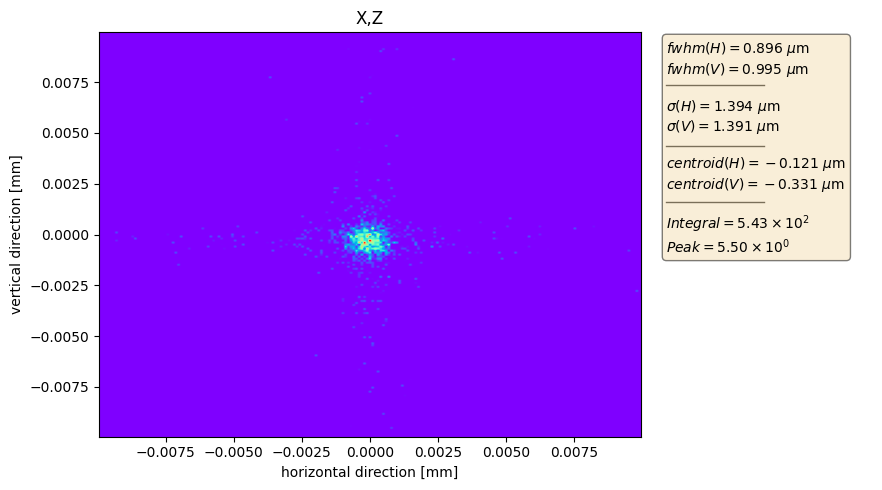

In [19]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [20]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.0003455714834023208, 0.002681373272666176)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4'] [-0.904951243664387, 1.4670900898725767, -3.1716796266031366, -0.9718451320215973, -0.00876910838184099, 0.0041566004374164, -0.5707110817150713, 4.613622857779706]


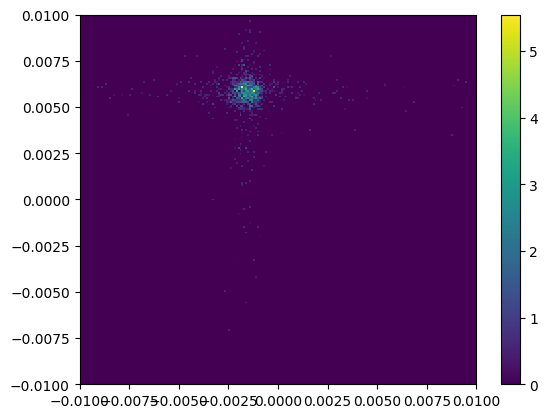

In [21]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [22]:
hist.data_2D.sum()

536.726902029518

In [23]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

0.006049329459917266 0.002732149443715175


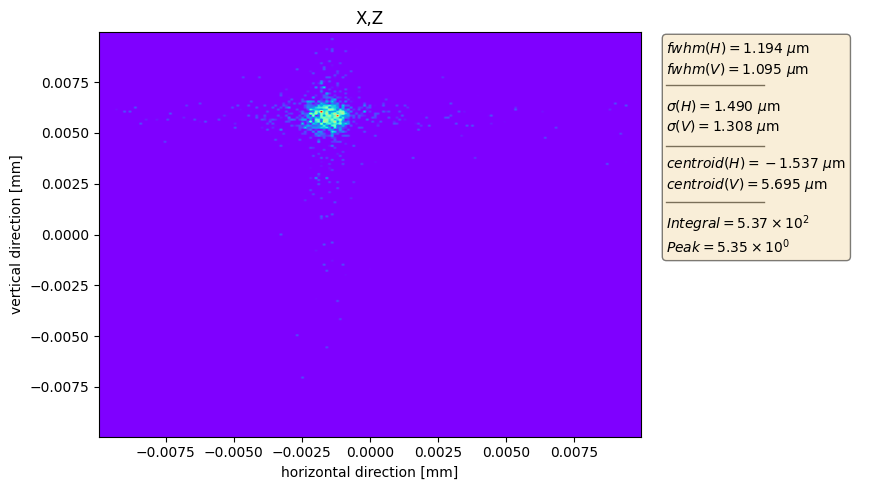

In [25]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [26]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.01, 0.01],
                            camera_yrange=[-0.01, 0.01],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [27]:
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-2e-3]}, seed=111)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/1022441631.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-2e-3]}, seed=111)


In [28]:
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    integral_threshold=100,
    base_sampler=base_sampler,
    raise_prune_exception=True,
    use_discrete_space=True
)

[I 2022-10-17 11:09:23,532] A new study created in memory with name: no-name-6e08e4e8-ba20-4e7a-8f11-5ee17667cab0


In [29]:
opt_trial.trials(20, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/2085722336.py:85: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.01, 0.01] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.01, 0.009198621771937626].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

In [30]:
opt_trial.study.best_trials

[FrozenTrial(number=1, values=[0.005179581203806279, 0.001931170455423877], datetime_start=datetime.datetime(2022, 10, 17, 11, 9, 29, 33922), datetime_complete=datetime.datetime(2022, 10, 17, 11, 9, 30, 205492), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0022173047639603063, 'vkb_3': -0.0065093414960113415, 'hkb_4': -0.5999999999999996, 'vkb_4': 2.7}, distributions={'hkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.009198621771937626, log=False, low=-0.01, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.009198621771937626, log=False, low=-0.01, step=0.0017453

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


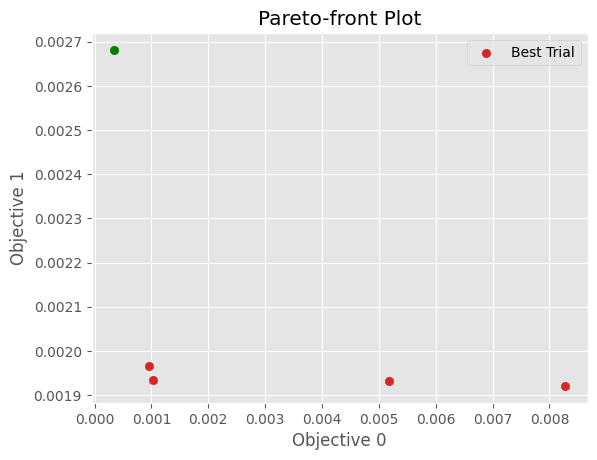

In [31]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [32]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-11.512660080961727 3.97272831507861
-11.049532162366967 1.308671699629507
-13.125155031093323 0.5837176573954637
-13.175803671906682 0.9046261809728454


[0.005179581203806279, 0.001931170455423877] 3.97272831507861


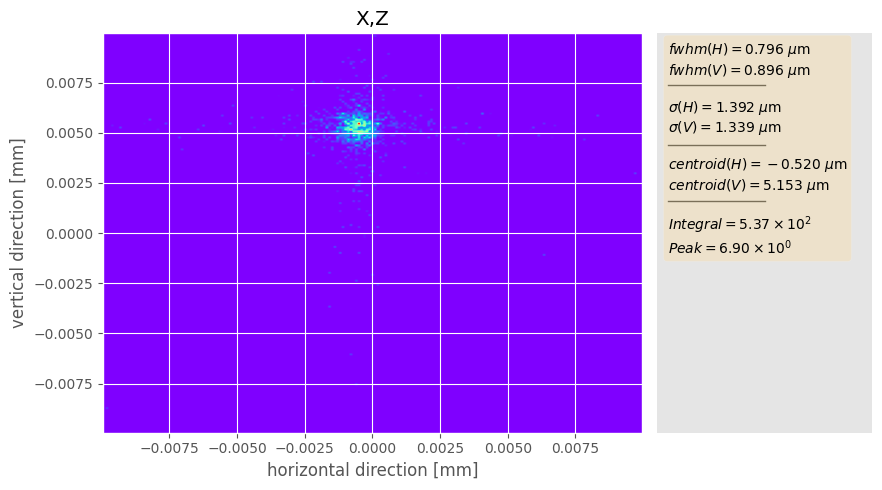

[0.008275063865359663, 0.0019207807739846517] 1.308671699629507


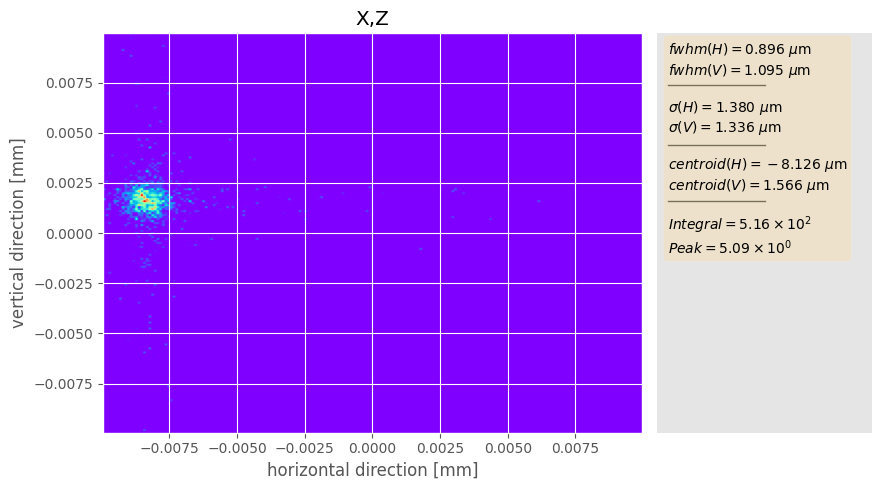

[0.0010311828220871668, 0.0019341133657254667] 0.5837176573954637


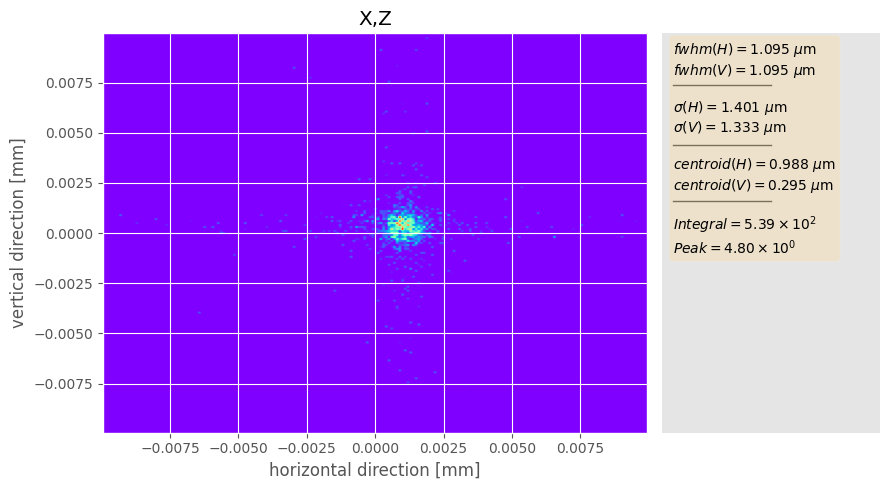

[0.0009645036013457372, 0.001965700359369592] 0.9046261809728454


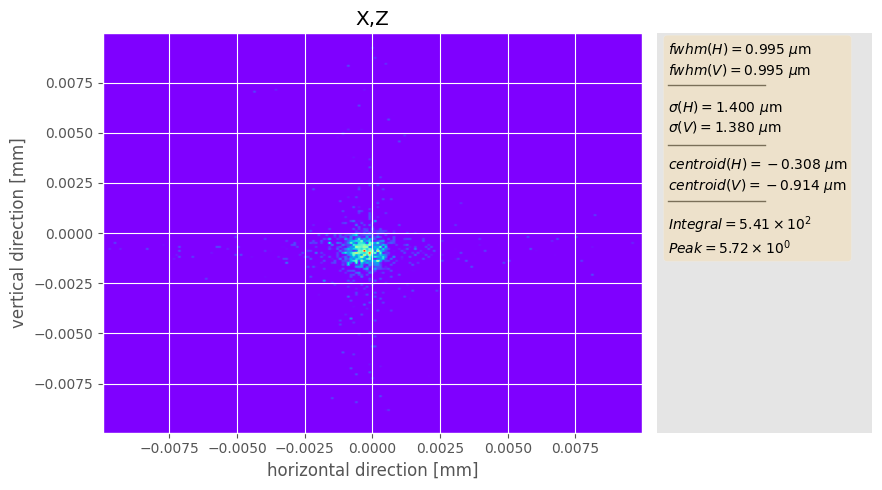

In [33]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [34]:
opt_trial.trials(20)

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.01, 0.01] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.01, 0.009198621771937626].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:35,475] Trial 20 finished with values: [0.003930564793242195, 0.00202060051712534] and parameters: {'hkb_1': 0.7230999999999996, 'vkb_1': -0.08860000000000046, 'hkb_2': 1.9112999999999998, 'vkb_2': -0.053800000000000736, 'hkb_3': 0.0039626340159546365, 'vkb_3': -0.01, 'hkb_4': 1.0, 'vkb_4': 2.7}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:38,361] Trial 21 finished with values: [0.005224646264154711, 0.0019325222080956374] and parameters: {'hkb_1': -0.32590000000000074, 'vkb_1': 0.10829999999999984, 'hkb_2': -1.8894000000000002, 'vkb_2': 1.3587999999999996, 'hkb_3': 0.005707963267948967, 'vkb_3': -0.003018682992022682, 'hkb_4': -0.7999999999999998, 'vkb_4': 1.1000000000000005}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.9999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:41,485] Trial 22 finished with values: [0.003113703439843217, 0.001925737898304009] and parameters: {'hkb_1': 0.6705999999999994, 'vkb_1': 1.621599999999999, 'hkb_2': -1.5709000000000004, 'vkb_2': 1.6464999999999996, 'hkb_3': 0.007453292519943295, 'vkb_3': -0.00825467074800567, 'hkb_4': -0.39999999999999947, 'vkb_4': 1.4000000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:44,620] Trial 23 finished with values: [0.0021356916886877703, 0.0018519326856048163] and parameters: {'hkb_1': 0.22559999999999913, 'vkb_1': 2.3907999999999996, 'hkb_2': 1.4527999999999999, 'vkb_2': -0.9140000000000006, 'hkb_3': 0.007453292519943295, 'vkb_3': -0.00825467074800567, 'hkb_4': 0.0, 'vkb_4': 0.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:47,366] Trial 24 finished with values: [0.0015893139355608907, 0.0020163787426305604] and parameters: {'hkb_1': 1.6217999999999995, 'vkb_1': 4.666699999999999, 'hkb_2': 0.04679999999999929, 'vkb_2': -1.0294000000000003, 'hkb_3': 0.0039626340159546365, 'vkb_3': -0.01, 'hkb_4': 0.3000000000000007, 'vkb_4': 0.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:50,241] Trial 25 finished with values: [0.0022148483407405492, 0.0018997827989495676] and parameters: {'hkb_1': 0.07259999999999955, 'vkb_1': 2.1233999999999993, 'hkb_2': 1.2176999999999998, 'vkb_2': -4.6117, 'hkb_3': 0.007453292519943295, 'vkb_3': -0.01, 'hkb_4': -1.9, 'vkb_4': 0.20000000000000018}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:53,093] Trial 26 finished with values: [0.0015004626092993136, 0.001954181425984335] and parameters: {'hkb_1': -1.2331000000000003, 'vkb_1': 0.4950999999999999, 'hkb_2': 1.1298999999999992, 'vkb_2': 0.3041999999999998, 'hkb_3': 0.009198621771937624, 'vkb_3': -0.01, 'hkb_4': 0.7000000000000002, 'vkb_4': 0.6000000000000005}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:56,646] Trial 27 finished with values: [0.0009713670749946017, 0.0020740707169105326] and parameters: {'hkb_1': -0.9477000000000002, 'vkb_1': -0.5878000000000005, 'hkb_2': -2.6122, 'vkb_2': -2.6186000000000003, 'hkb_3': -0.01, 'vkb_3': -0.00825467074800567, 'hkb_4': -4.1, 'vkb_4': -0.7999999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:10:59,678] Trial 28 finished with values: [0.0017830998366566047, 0.0020599590307634947] and parameters: {'hkb_1': -0.3136000000000001, 'vkb_1': 4.331899999999999, 'hkb_2': 1.8323999999999998, 'vkb_2': 0.8387999999999991, 'hkb_3': 0.009198621771937624, 'vkb_3': -0.01, 'hkb_4': 1.0, 'vkb_4': 1.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:02,925] Trial 29 finished with values: [0.00062034612064633, 0.0020244904174156948] and parameters: {'hkb_1': -0.5887000000000002, 'vkb_1': -0.3747000000000007, 'hkb_2': -1.7032000000000003, 'vkb_2': -0.30410000000000004, 'hkb_3': -0.00825467074800567, 'vkb_3': -0.01, 'hkb_4': -3.5999999999999996, 'vkb_4': -1.5999999999999996}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:06,042] Trial 30 finished with values: [0.0009518568304717575, 0.0020187094774475364] and parameters: {'hkb_1': -0.7531000000000008, 'vkb_1': 3.451699999999999, 'hkb_2': -0.5004, 'vkb_2': -2.0762, 'hkb_3': 0.0022173047639603063, 'vkb_3': -0.01, 'hkb_4': -2.0999999999999996, 'vkb_4': -0.7999999999999998}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oas

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:08,935] Trial 31 finished with values: [0.002144669356200614, 0.001960856557976998] and parameters: {'hkb_1': 1.0291999999999994, 'vkb_1': 2.021699999999999, 'hkb_2': -0.002100000000000435, 'vkb_2': 0.27029999999999976, 'hkb_3': 0.009198621771937624, 'vkb_3': -0.00825467074800567, 'hkb_4': 1.1000000000000005, 'vkb_4': 0.40000000000000036}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:12,875] Trial 32 finished with values: [0.0013310271373457184, 0.0019732310741092567] and parameters: {'hkb_1': -3.0677000000000003, 'vkb_1': 4.372499999999999, 'hkb_2': -1.2595000000000005, 'vkb_2': -0.31620000000000026, 'hkb_3': -0.004764012244017011, 'vkb_3': -0.01, 'hkb_4': -2.5, 'vkb_4': 0.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:15,862] Trial 33 finished with values: [0.0014554853816262695, 0.0020423677220022664] and parameters: {'hkb_1': -2.4175000000000004, 'vkb_1': 3.6646, 'hkb_2': 1.341099999999999, 'vkb_2': -2.8783000000000003, 'hkb_3': 0.0022173047639603063, 'vkb_3': -0.01, 'hkb_4': 0.10000000000000053, 'vkb_4': -0.09999999999999964}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:19,800] Trial 34 finished with values: [0.000748830625605644, 0.001962961820426789] and parameters: {'hkb_1': -2.1685000000000003, 'vkb_1': 4.815299999999999, 'hkb_2': -0.43290000000000006, 'vkb_2': -4.4528, 'hkb_3': -0.004764012244017011, 'vkb_3': -0.01, 'hkb_4': -2.5, 'vkb_4': -0.09999999999999964}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:23,996] Trial 35 finished with values: [0.000906820743601884, 0.0019570511455814345] and parameters: {'hkb_1': -2.1327000000000003, 'vkb_1': 2.612399999999999, 'hkb_2': -0.009600000000000719, 'vkb_2': -4.2083, 'hkb_3': -0.0065093414960113415, 'vkb_3': -0.01, 'hkb_4': -4.0, 'vkb_4': -0.1999999999999993}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:28,194] Trial 36 finished with values: [0.001252408892184583, 0.002039704090111337] and parameters: {'hkb_1': -1.3214000000000001, 'vkb_1': 4.0337, 'hkb_2': -2.3599, 'vkb_2': -4.4932, 'hkb_3': -0.004764012244017011, 'vkb_3': -0.00825467074800567, 'hkb_4': -3.9, 'vkb_4': -2.3}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:31,414] Trial 37 finished with values: [0.0007652890046387361, 0.002003112407170152] and parameters: {'hkb_1': -1.4291000000000005, 'vkb_1': 2.847599999999999, 'hkb_2': -2.3054, 'vkb_2': 2.006499999999999, 'hkb_3': -0.00825467074800567, 'vkb_3': -0.00825467074800567, 'hkb_4': -3.5999999999999996, 'vkb_4': -2.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:34,991] Trial 38 finished with values: [0.000769431334634194, 0.0019328732757673476] and parameters: {'hkb_1': -0.6065000000000005, 'vkb_1': 4.418999999999999, 'hkb_2': -2.5915000000000004, 'vkb_2': -1.5597000000000003, 'hkb_3': 0.0022173047639603063, 'vkb_3': -0.01, 'hkb_4': -1.0, 'vkb_4': -1.5999999999999996}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:11:38,466] Trial 39 finished with values: [0.00011706424501731692, 0.0019193138603074685] and parameters: {'hkb_1': -2.814, 'vkb_1': 3.2677999999999994, 'hkb_2': -1.3675000000000002, 'vkb_2': -3.0119000000000002, 'hkb_3': 0.009198621771937624, 'vkb_3': -0.01, 'hkb_4': 0.6000000000000005, 'vkb_4': -0.7999999999999998}. 


In [35]:
opt_trial.study.best_trials

[FrozenTrial(number=23, values=[0.0021356916886877703, 0.0018519326856048163], datetime_start=datetime.datetime(2022, 10, 17, 11, 10, 41, 486401), datetime_complete=datetime.datetime(2022, 10, 17, 11, 10, 44, 620081), params={'hkb_1': 0.22559999999999913, 'vkb_1': 2.3907999999999996, 'hkb_2': 1.4527999999999999, 'vkb_2': -0.9140000000000006, 'hkb_3': 0.007453292519943295, 'vkb_3': -0.00825467074800567, 'hkb_4': 0.0, 'vkb_4': 0.5}, distributions={'hkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.009198621771937626, log=False, low=-0.01, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.0091986

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


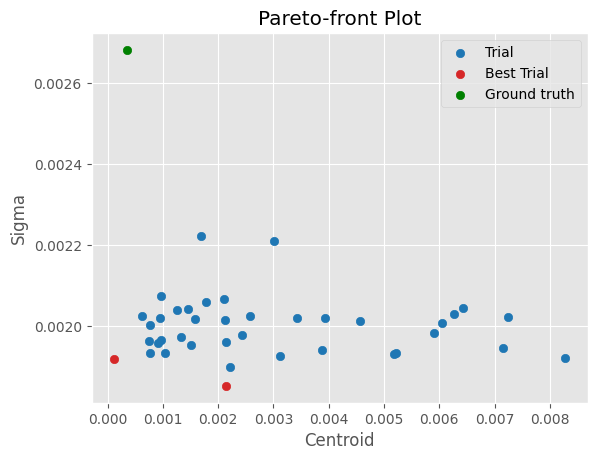

In [36]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [37]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-12.440490199088625
-15.308575192391661


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.0021356916886877703, 0.0018519326856048163] 1.757140580520321
BeamParameterOutput(parameter_value=0.0022240300546337677, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c25bce0a0>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c21360610>, dw=<orangecontr

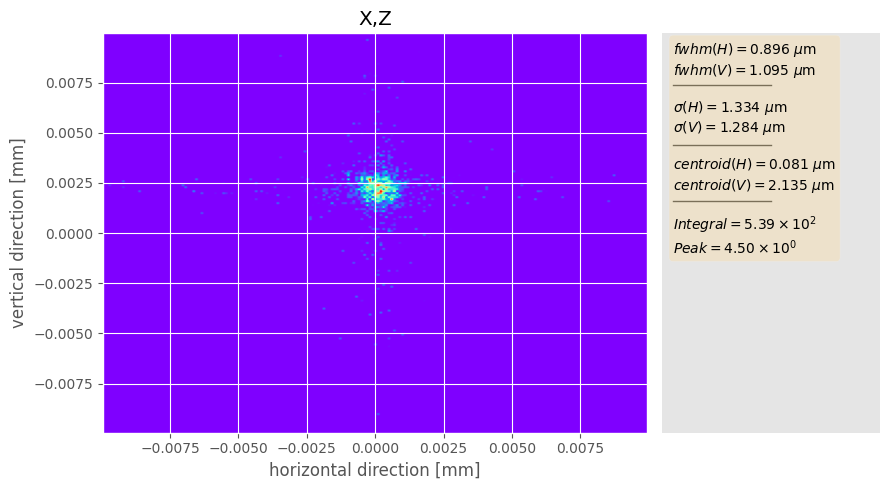

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.00011706424501731692, 0.0019193138603074685] 0.5627784363111459
BeamParameterOutput(parameter_value=0.00015816010622667786, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7be0589490>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c248f7790>, dw=<orangeco

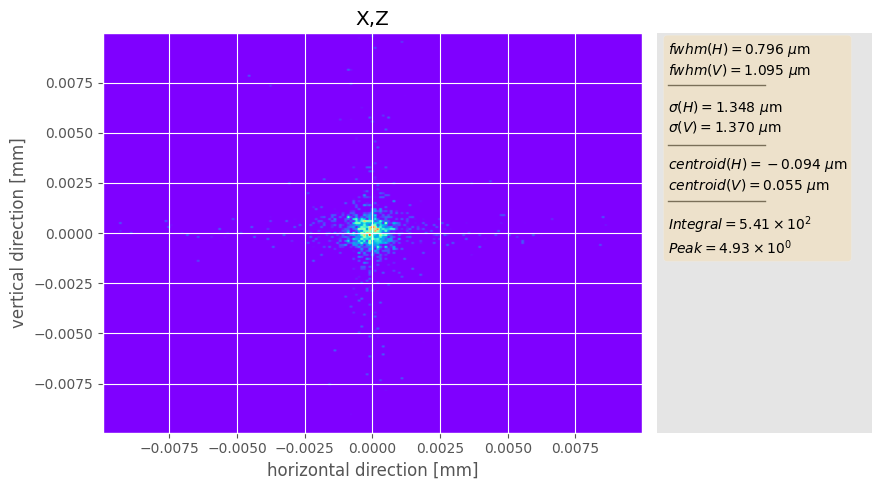

In [38]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [40]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

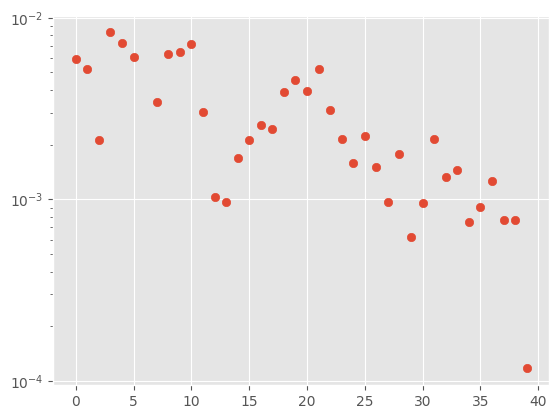

In [41]:
plt.scatter(tnums, centroids)
plt.yscale('log')

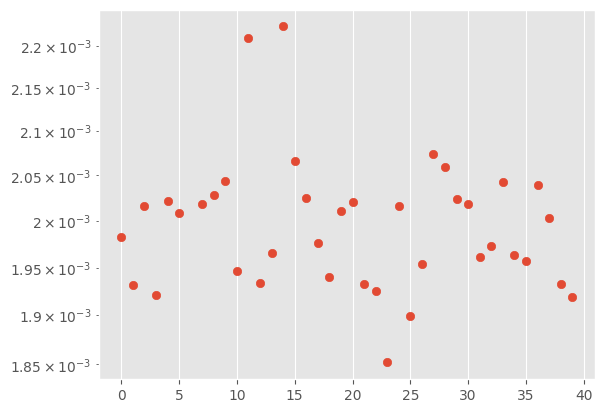

In [42]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

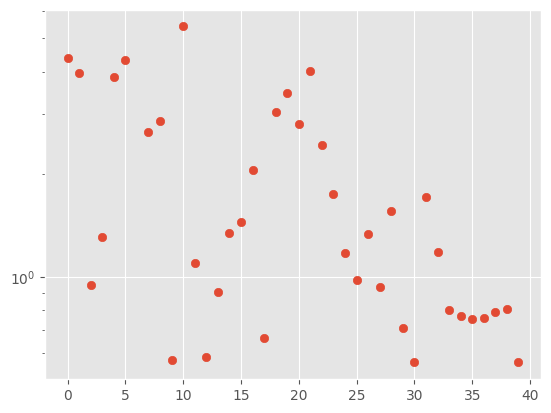

In [43]:
plt.scatter(tnums, wsums)
plt.yscale('log')

### Different starting structure

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


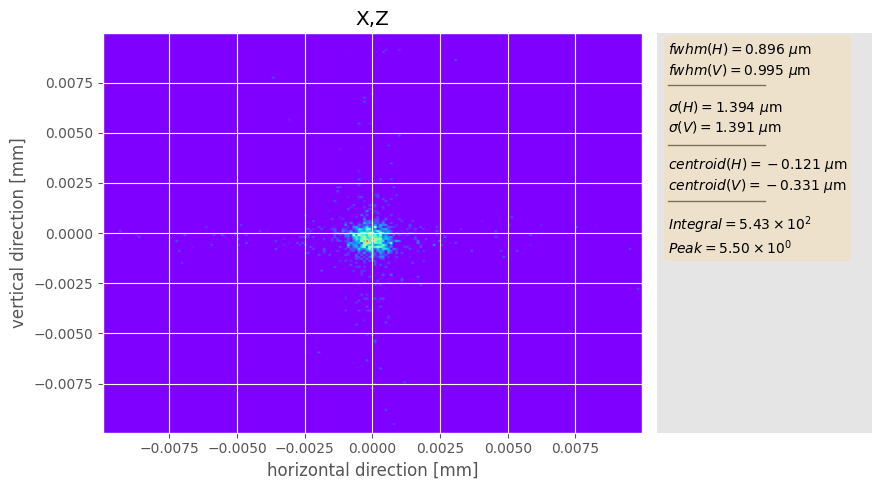

In [44]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [45]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.0003455714834023208, 0.002681373272666176)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4'] [0.74863325313527, 4.795514755588265, 0.6866336197168978, 3.7573097004238747, 0.0023674849764410387, -0.009559362088024284, -1.0313290982144996, -4.1203665243965935]


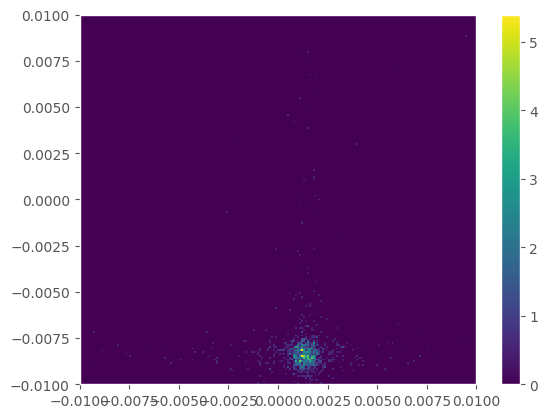

In [46]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [47]:
hist.data_2D.sum()

515.5397147835492

In [48]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
0.008419545404308957 0.00300863636611331


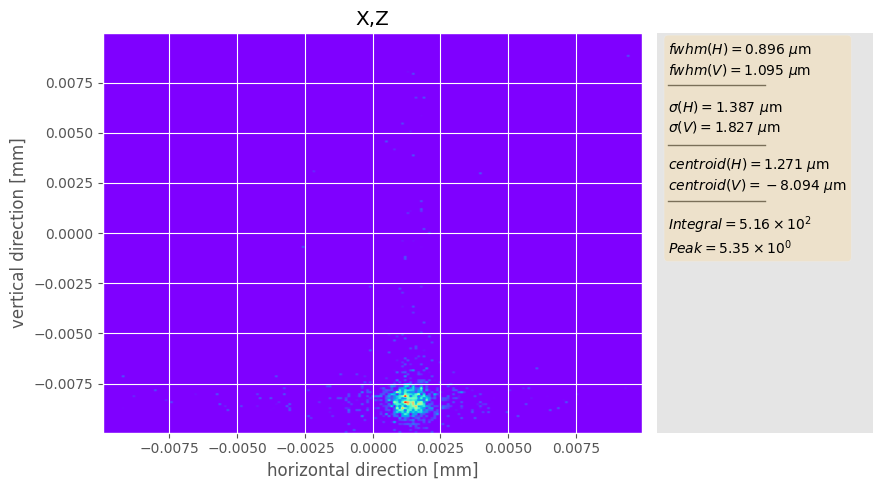

In [49]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [50]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.01, 0.01],
                            camera_yrange=[-0.01, 0.01],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [51]:
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-2e-3]}, seed=111)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/1022441631.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-2e-3]}, seed=111)


In [52]:
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    integral_threshold=100,
    base_sampler=base_sampler,
    raise_prune_exception=True,
    use_discrete_space=True
)

[I 2022-10-17 11:13:47,338] A new study created in memory with name: no-name-4c0710ef-2a4d-49e5-aa29-2fc5d8a0e333


In [53]:
opt_trial.trials(50, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/2085722336.py:85: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.01, 0.01] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.01, 0.009198621771937626].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

In [54]:
opt_trial.study.best_trials

[FrozenTrial(number=20, values=[0.00025220558722897386, 0.0019254412848675262], datetime_start=datetime.datetime(2022, 10, 17, 11, 14, 32, 745672), datetime_complete=datetime.datetime(2022, 10, 17, 11, 14, 35, 612896), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.003018682992022682, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.20000000000000018, 'vkb_4': 4.5}, distributions={'hkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.009198621771937626, log=False, low=-0.01, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.009198621771937626, log=False, low=-0.01, step=0.00

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


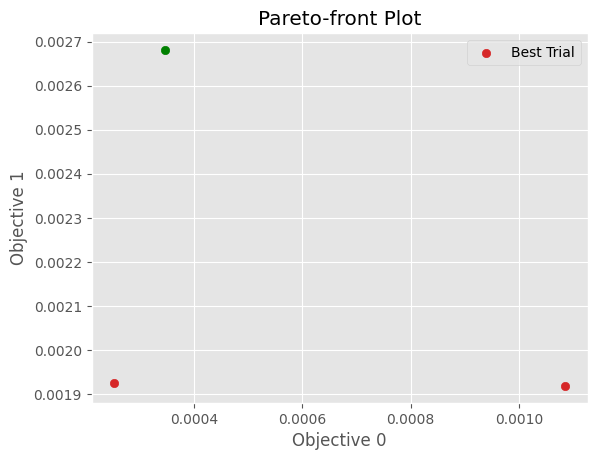

In [55]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [56]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-14.5378660793392 0.543248038888781
-13.082333309903373 1.0115705808903543


[0.00025220558722897386, 0.0019254412848675262] 0.543248038888781


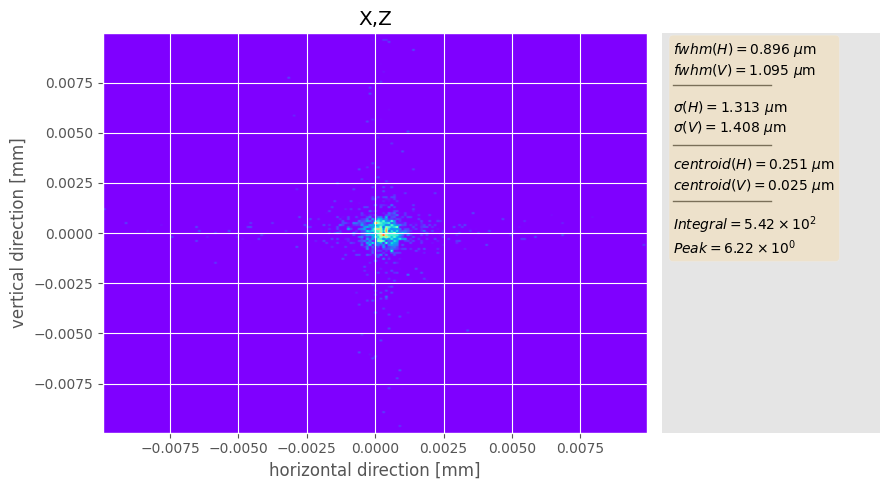

[0.0010852943187896885, 0.0019180825905410715] 1.0115705808903543


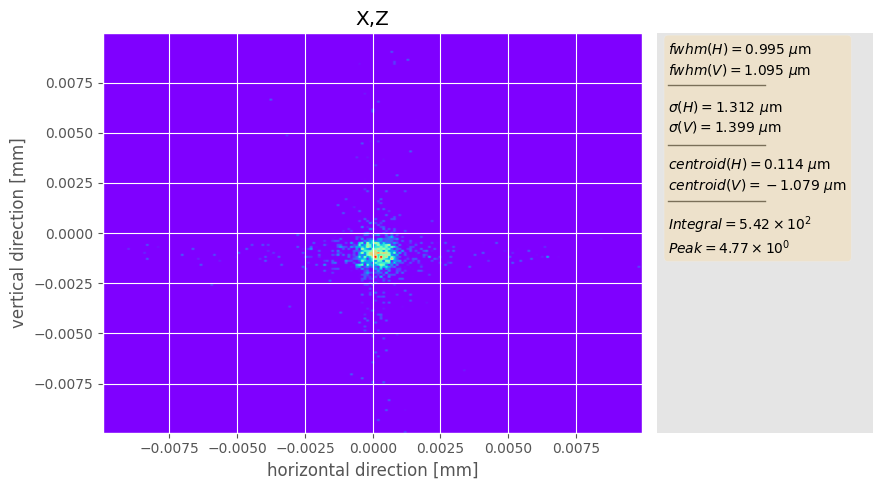

In [57]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [58]:
opt_trial.trials(50)

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.01, 0.01] and step=0.0017453292519943296, but the range is not divisible by `step`. It will be replaced by [-0.01, 0.009198621771937626].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:23,688] Trial 50 finished with values: [0.0017742409454791365, 0.0020343368157873637] and parameters: {'hkb_1': 3.3808999999999987, 'vkb_1': -0.7171000000000003, 'hkb_2': -0.24880000000000013, 'vkb_2': -0.8469000000000007, 'hkb_3': -0.00825467074800567, 'vkb_3': 0.005707963267948967, 'hkb_4': -2.0, 'vkb_4': 4.800000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:26,910] Trial 51 finished with values: [0.0010659071519007295, 0.0020247056888230476] and parameters: {'hkb_1': 2.304499999999999, 'vkb_1': -2.3595, 'hkb_2': 0.3592999999999993, 'vkb_2': -1.0937000000000006, 'hkb_3': 0.007453292519943295, 'vkb_3': 0.007453292519943295, 'hkb_4': 4.1, 'vkb_4': 4.800000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicati

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:30,973] Trial 52 finished with values: [0.0005947686628141444, 0.0020014142511283616] and parameters: {'hkb_1': -0.8179000000000007, 'vkb_1': -0.45199999999999996, 'hkb_2': 1.3806999999999992, 'vkb_2': 1.8091999999999997, 'hkb_3': -0.0012733537400283525, 'vkb_3': 0.009198621771937624, 'hkb_4': 1.4000000000000004, 'vkb_4': 4.200000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.99999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:34,945] Trial 53 finished with values: [0.0011080450944249151, 0.002007776109917305] and parameters: {'hkb_1': 4.3245999999999984, 'vkb_1': -0.019000000000000128, 'hkb_2': 0.3550999999999993, 'vkb_2': -2.5564, 'hkb_3': 0.00047197551196597777, 'vkb_3': 0.009198621771937624, 'hkb_4': 2.5, 'vkb_4': 4.9}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:39,323] Trial 54 finished with values: [0.0016891687522577292, 0.001973926648934387] and parameters: {'hkb_1': 2.7445999999999993, 'vkb_1': -0.5472000000000001, 'hkb_2': 0.9028999999999998, 'vkb_2': -4.5417, 'hkb_3': 0.0039626340159546365, 'vkb_3': 0.007453292519943295, 'hkb_4': 0.6000000000000005, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:43,532] Trial 55 finished with values: [0.0011438543618727266, 0.0019911090889130983] and parameters: {'hkb_1': -1.0671000000000004, 'vkb_1': -3.3588000000000005, 'hkb_2': 1.4694999999999991, 'vkb_2': -0.43680000000000074, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.009198621771937624, 'hkb_4': -1.5, 'vkb_4': 4.800000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warning

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:47,489] Trial 56 finished with values: [0.0009139944810109317, 0.0020137669256521844] and parameters: {'hkb_1': 4.0604, 'vkb_1': -3.6367000000000003, 'hkb_2': 0.7224999999999993, 'vkb_2': 1.3557999999999995, 'hkb_3': -0.004764012244017011, 'vkb_3': 0.009198621771937624, 'hkb_4': 1.0, 'vkb_4': 4.700000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:51,318] Trial 57 finished with values: [0.0006119228216576567, 0.0019450613557654296] and parameters: {'hkb_1': 2.3234999999999992, 'vkb_1': -2.3764000000000003, 'hkb_2': 2.4861999999999993, 'vkb_2': -0.7185000000000006, 'hkb_3': -0.0012733537400283525, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.3000000000000007, 'vkb_4': 4.700000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:55,158] Trial 58 finished with values: [0.0005391289526795694, 0.001932914213164236] and parameters: {'hkb_1': 3.223699999999999, 'vkb_1': -4.1125, 'hkb_2': 0.058999999999999275, 'vkb_2': -1.6690000000000005, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.007453292519943295, 'hkb_4': -0.5, 'vkb_4': 4.700000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:16:59,154] Trial 59 finished with values: [0.00046434236121760993, 0.0019528293335724911] and parameters: {'hkb_1': 2.151, 'vkb_1': 1.2967999999999993, 'hkb_2': 1.1235999999999997, 'vkb_2': -1.1096000000000004, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 3.0, 'vkb_4': 4.4}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.a

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:03,269] Trial 60 finished with values: [0.0004618664135101714, 0.001970504937489143] and parameters: {'hkb_1': -1.1124000000000005, 'vkb_1': 4.444099999999999, 'hkb_2': 2.7296999999999993, 'vkb_2': 0.25399999999999956, 'hkb_3': 0.005707963267948967, 'vkb_3': 0.009198621771937624, 'hkb_4': 3.0, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:06,865] Trial 61 finished with values: [0.0005209575627118272, 0.0019707136990299314] and parameters: {'hkb_1': -0.7231000000000005, 'vkb_1': -2.4126000000000003, 'hkb_2': 2.061799999999999, 'vkb_2': 1.4586999999999994, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.007453292519943295, 'hkb_4': 3.0999999999999996, 'vkb_4': 4.800000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:10,847] Trial 62 finished with values: [0.0005580643086052074, 0.00198833407231242] and parameters: {'hkb_1': 4.520899999999999, 'vkb_1': -0.8307000000000002, 'hkb_2': 2.5332999999999997, 'vkb_2': -3.6226000000000003, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.007453292519943295, 'hkb_4': -0.09999999999999964, 'vkb_4': 4.800000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999]

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:14,766] Trial 63 finished with values: [0.002711214198320403, 0.002050143228902593] and parameters: {'hkb_1': 2.4148999999999994, 'vkb_1': 1.4555999999999996, 'hkb_2': 4.2943, 'vkb_2': -4.5354, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.6000000000000005, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:18,887] Trial 64 finished with values: [0.0015745109880894181, 0.0019796154726388227] and parameters: {'hkb_1': -2.1369000000000002, 'vkb_1': -4.4442, 'hkb_2': 4.2879999999999985, 'vkb_2': 0.15659999999999918, 'hkb_3': 0.007453292519943295, 'vkb_3': 0.007453292519943295, 'hkb_4': 4.4, 'vkb_4': 4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:22,885] Trial 65 finished with values: [0.0005684278766736326, 0.001977139314210679] and parameters: {'hkb_1': -4.6399, 'vkb_1': -0.29720000000000013, 'hkb_2': 3.603399999999999, 'vkb_2': -0.5193000000000003, 'hkb_3': 0.007453292519943295, 'vkb_3': 0.009198621771937624, 'hkb_4': 2.3000000000000007, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:26,538] Trial 66 finished with values: [0.0007242461688071556, 0.002018274054339836] and parameters: {'hkb_1': -1.6148000000000002, 'vkb_1': -2.031, 'hkb_2': 4.793699999999999, 'vkb_2': -3.4026, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.20000000000000018, 'vkb_4': 4.9}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:30,211] Trial 67 finished with values: [0.002770746481757382, 0.002026902772795618] and parameters: {'hkb_1': -3.8, 'vkb_1': 1.1641999999999992, 'hkb_2': 3.7094999999999985, 'vkb_2': -4.4719, 'hkb_3': -0.003018682992022682, 'vkb_3': 0.009198621771937624, 'hkb_4': 3.200000000000001, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:34,248] Trial 68 finished with values: [0.0005768635072456571, 0.001975791772505807] and parameters: {'hkb_1': -0.013700000000000045, 'vkb_1': -3.7873, 'hkb_2': 3.181099999999999, 'vkb_2': -4.1565, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.009198621771937624, 'hkb_4': -0.2999999999999998, 'vkb_4': 3.9000000000000004}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:38,419] Trial 69 finished with values: [0.0011702799457183662, 0.0019990878588664242] and parameters: {'hkb_1': -2.9677000000000002, 'vkb_1': -4.3364, 'hkb_2': 1.365499999999999, 'vkb_2': -2.6514, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 4.600000000000001, 'vkb_4': 4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:42,659] Trial 70 finished with values: [0.0007552325941350977, 0.0019483027203915095] and parameters: {'hkb_1': 2.714899999999999, 'vkb_1': -0.9676, 'hkb_2': 3.0236, 'vkb_2': -1.9180000000000001, 'hkb_3': -0.0012733537400283525, 'vkb_3': 0.007453292519943295, 'hkb_4': 1.2000000000000002, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:47,638] Trial 71 finished with values: [0.00031684402434958256, 0.0019270795770436925] and parameters: {'hkb_1': -4.3772, 'vkb_1': 3.035399999999999, 'hkb_2': 0.6816999999999993, 'vkb_2': -3.5700000000000003, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 3.5999999999999996, 'vkb_4': 4.4}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:51,952] Trial 72 finished with values: [0.00172762169432315, 0.0020480833712180303] and parameters: {'hkb_1': 0.8664999999999994, 'vkb_1': -1.5429000000000004, 'hkb_2': 1.3629999999999995, 'vkb_2': -4.0443, 'hkb_3': -0.00825467074800567, 'vkb_3': 0.007453292519943295, 'hkb_4': 0.10000000000000053, 'vkb_4': 3.8000000000000007}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:17:56,796] Trial 73 finished with values: [0.0008069163843292226, 0.0019100040628475215] and parameters: {'hkb_1': -3.0994, 'vkb_1': -2.9945000000000004, 'hkb_2': -3.1238, 'vkb_2': 2.3915999999999995, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.009198621771937624, 'hkb_4': -1.1999999999999997, 'vkb_4': 4.300000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/A

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:01,032] Trial 74 finished with values: [0.0008770498934710851, 0.0020001414524476813] and parameters: {'hkb_1': -2.2472000000000003, 'vkb_1': -0.15480000000000071, 'hkb_2': -3.6791, 'vkb_2': -0.8431000000000006, 'hkb_3': -0.00825467074800567, 'vkb_3': 0.007453292519943295, 'hkb_4': -1.5999999999999996, 'vkb_4': 5.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:05,159] Trial 75 finished with values: [0.0011179287892673555, 0.0019441930094408017] and parameters: {'hkb_1': 0.28279999999999994, 'vkb_1': -2.6038, 'hkb_2': 3.2637, 'vkb_2': -2.1124, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 2.8000000000000007, 'vkb_4': 3.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:09,933] Trial 76 finished with values: [0.000749033586748378, 0.0020181637009452557] and parameters: {'hkb_1': -4.3654, 'vkb_1': 2.2517999999999994, 'hkb_2': 2.6172999999999993, 'vkb_2': 2.6350999999999996, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 4.1, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicatio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:14,429] Trial 77 finished with values: [0.0006973703884360887, 0.0019739177140448544] and parameters: {'hkb_1': -4.3266, 'vkb_1': -0.7173000000000007, 'hkb_2': 0.8463999999999992, 'vkb_2': -0.6365000000000007, 'hkb_3': -0.0012733537400283525, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.20000000000000018, 'vkb_4': 4.800000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warni

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:18,888] Trial 78 finished with values: [0.0013669604452298152, 0.001957850008814216] and parameters: {'hkb_1': -0.007400000000000517, 'vkb_1': -0.8748000000000005, 'hkb_2': -4.8792, 'vkb_2': 3.0100999999999996, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.007453292519943295, 'hkb_4': -1.5999999999999996, 'vkb_4': 4.700000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:23,545] Trial 79 finished with values: [0.0010704465769041805, 0.0019216611990980302] and parameters: {'hkb_1': -3.5077, 'vkb_1': -3.1876, 'hkb_2': -3.9118000000000004, 'vkb_2': -1.2952000000000004, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.007453292519943295, 'hkb_4': -0.7000000000000002, 'vkb_4': 4.200000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:27,994] Trial 80 finished with values: [0.0035966943870814534, 0.002104974222864193] and parameters: {'hkb_1': -3.5040000000000004, 'vkb_1': -3.4717000000000002, 'hkb_2': -3.3332, 'vkb_2': 0.33699999999999974, 'hkb_3': -0.003018682992022682, 'vkb_3': 0.0039626340159546365, 'hkb_4': -1.9, 'vkb_4': 4.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:32,223] Trial 81 finished with values: [0.0010347547272710896, 0.0019391022581790028] and parameters: {'hkb_1': 2.068999999999999, 'vkb_1': 0.3417999999999992, 'hkb_2': 0.3074999999999992, 'vkb_2': 4.952399999999999, 'hkb_3': -0.01, 'vkb_3': 0.007453292519943295, 'hkb_4': -1.9, 'vkb_4': 4.4}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:36,881] Trial 82 finished with values: [0.0008291117996600937, 0.001967915122095082] and parameters: {'hkb_1': -1.0715000000000003, 'vkb_1': -3.7808, 'hkb_2': -2.6957, 'vkb_2': -2.0471000000000004, 'hkb_3': -0.003018682992022682, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.10000000000000053, 'vkb_4': 3.700000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:41,655] Trial 83 finished with values: [0.0005115143013307499, 0.0018934383459546034] and parameters: {'hkb_1': -4.1534, 'vkb_1': -0.2583000000000002, 'hkb_2': -3.3552, 'vkb_2': 1.1030999999999995, 'hkb_3': -0.00825467074800567, 'vkb_3': 0.009198621771937624, 'hkb_4': -1.2999999999999998, 'vkb_4': 4.300000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:46,257] Trial 84 finished with values: [0.0006263562958682977, 0.0019908189851601337] and parameters: {'hkb_1': -3.4091000000000005, 'vkb_1': 1.6171999999999995, 'hkb_2': 0.6936999999999998, 'vkb_2': -0.5209000000000001, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 2.8000000000000007, 'vkb_4': 4.200000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:50,474] Trial 85 finished with values: [0.0008662277548622526, 0.0019560342966931806] and parameters: {'hkb_1': 0.20979999999999954, 'vkb_1': -3.8215000000000003, 'hkb_2': -4.4326, 'vkb_2': 3.3207999999999984, 'hkb_3': 0.00047197551196597777, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.5, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:54,623] Trial 86 finished with values: [0.0008986624772241361, 0.0019211258842437684] and parameters: {'hkb_1': -2.5569, 'vkb_1': -4.562, 'hkb_2': -2.8557, 'vkb_2': -1.1650000000000005, 'hkb_3': 0.0039626340159546365, 'vkb_3': 0.007453292519943295, 'hkb_4': 2.2, 'vkb_4': 4.300000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:18:59,012] Trial 87 finished with values: [0.00016772160672599986, 0.0019509728625261918] and parameters: {'hkb_1': 0.6637999999999993, 'vkb_1': -3.4345, 'hkb_2': 4.8362, 'vkb_2': -3.2417000000000002, 'hkb_3': 0.005707963267948967, 'vkb_3': 0.009198621771937624, 'hkb_4': 2.6000000000000005, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Appl

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:04,067] Trial 88 finished with values: [0.000602113857513037, 0.002010798020937286] and parameters: {'hkb_1': 2.394099999999999, 'vkb_1': -3.0712, 'hkb_2': 4.3889, 'vkb_2': -3.6329000000000002, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 2.8000000000000007, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:09,062] Trial 89 finished with values: [0.0014747933040487437, 0.0020317833279363995] and parameters: {'hkb_1': -1.1821000000000002, 'vkb_1': 2.8945999999999996, 'hkb_2': 4.493599999999999, 'vkb_2': -3.6825, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 3.5, 'vkb_4': 3.0999999999999996}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applicat

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:13,974] Trial 90 finished with values: [0.0016978186596940444, 0.0019976152451243495] and parameters: {'hkb_1': -3.9268, 'vkb_1': -4.9129, 'hkb_2': -1.9720000000000004, 'vkb_2': -3.8588, 'hkb_3': -0.003018682992022682, 'vkb_3': 0.007453292519943295, 'hkb_4': 2.1000000000000005, 'vkb_4': 4.700000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/O

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:18,835] Trial 91 finished with values: [0.001344416407367779, 0.0020255258910862597] and parameters: {'hkb_1': -3.4885, 'vkb_1': 0.6679999999999993, 'hkb_2': 3.4169, 'vkb_2': -2.7642, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.007453292519943295, 'hkb_4': 3.200000000000001, 'vkb_4': 4.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:23,221] Trial 92 finished with values: [0.0008411112843728607, 0.0019758845135971624] and parameters: {'hkb_1': 1.065199999999999, 'vkb_1': -4.0367, 'hkb_2': 0.3710999999999993, 'vkb_2': -2.0323, 'hkb_3': 0.00047197551196597777, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.7000000000000002, 'vkb_4': 3.8000000000000007}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/App

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:27,770] Trial 93 finished with values: [0.0009781413195658918, 0.001921529715409374] and parameters: {'hkb_1': 1.646399999999999, 'vkb_1': -3.6402, 'hkb_2': 0.8356999999999992, 'vkb_2': -4.3582, 'hkb_3': 0.0039626340159546365, 'vkb_3': 0.009198621771937624, 'hkb_4': 1.3000000000000007, 'vkb_4': 5.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:32,530] Trial 94 finished with values: [0.0015478522171026667, 0.001986121281708329] and parameters: {'hkb_1': -2.7399, 'vkb_1': 1.7271999999999998, 'hkb_2': -4.6899, 'vkb_2': 3.0432999999999986, 'hkb_3': -0.00825467074800567, 'vkb_3': 0.005707963267948967, 'hkb_4': -1.5, 'vkb_4': 4.700000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:37,101] Trial 95 finished with values: [7.701227663551075e-05, 0.0019561659010259302] and parameters: {'hkb_1': -4.067, 'vkb_1': 1.2246999999999995, 'hkb_2': 4.460899999999999, 'vkb_2': -1.1832000000000003, 'hkb_3': 0.007453292519943295, 'vkb_3': 0.009198621771937624, 'hkb_4': 2.9000000000000004, 'vkb_4': 4.600000000000001}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:43,372] Trial 96 finished with values: [0.0026768596005841932, 0.0019372757042322478] and parameters: {'hkb_1': -4.4438, 'vkb_1': 0.5240999999999998, 'hkb_2': 0.43019999999999925, 'vkb_2': 0.3840999999999992, 'hkb_3': 0.0039626340159546365, 'vkb_3': 0.009198621771937624, 'hkb_4': 4.800000000000001, 'vkb_4': 5.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:50,478] Trial 97 finished with values: [0.0009313503564143191, 0.0019733309246493056] and parameters: {'hkb_1': -3.5969, 'vkb_1': -1.6876000000000002, 'hkb_2': -3.1412000000000004, 'vkb_2': -1.8948000000000005, 'hkb_3': -0.004764012244017011, 'vkb_3': 0.009198621771937624, 'hkb_4': 1.0, 'vkb_4': 4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:19:55,683] Trial 98 finished with values: [0.0026714907190756526, 0.0020331365764253307] and parameters: {'hkb_1': -2.4873000000000003, 'vkb_1': -2.5599000000000003, 'hkb_2': 3.7896, 'vkb_2': 4.339099999999998, 'hkb_3': -0.0065093414960113415, 'vkb_3': 0.005707963267948967, 'hkb_4': -2.8, 'vkb_4': 4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-5, 5] and step=9.999999999999999e-05, but the range is not divisible by `step`. It will be replaced by [-5, 4.999999999999999].
  warnings.warn(
/Applications/Oasys1.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 11:20:01,049] Trial 99 finished with values: [0.0013423681654721414, 0.0020041266361136238] and parameters: {'hkb_1': -2.2463, 'vkb_1': 0.43709999999999916, 'hkb_2': 2.3432999999999993, 'vkb_2': -2.9261000000000004, 'hkb_3': 0.009198621771937624, 'vkb_3': 0.009198621771937624, 'hkb_4': 4.800000000000001, 'vkb_4': 4.4}. 


In [59]:
opt_trial.study.best_trials

[FrozenTrial(number=20, values=[0.00025220558722897386, 0.0019254412848675262], datetime_start=datetime.datetime(2022, 10, 17, 11, 14, 32, 745672), datetime_complete=datetime.datetime(2022, 10, 17, 11, 14, 35, 612896), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.003018682992022682, 'vkb_3': 0.009198621771937624, 'hkb_4': 0.20000000000000018, 'vkb_4': 4.5}, distributions={'hkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_1': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'vkb_2': FloatDistribution(high=4.999999999999999, log=False, low=-5.0, step=9.999999999999999e-05), 'hkb_3': FloatDistribution(high=0.009198621771937626, log=False, low=-0.01, step=0.0017453292519943296), 'vkb_3': FloatDistribution(high=0.009198621771937626, log=False, low=-0.01, step=0.00

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


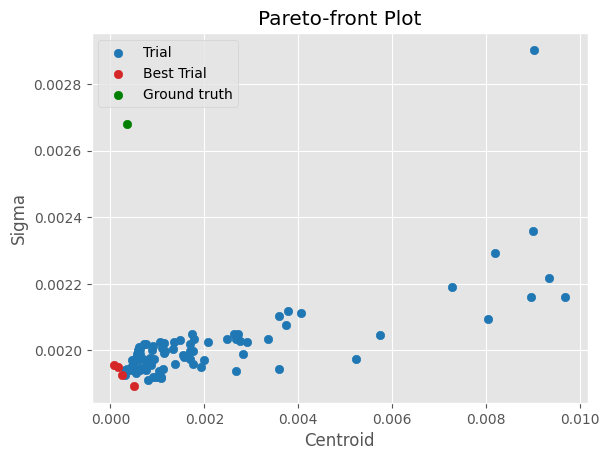

In [60]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [61]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-14.5378660793392
-13.847495885415185
-14.932632182854057
-15.708314606485276


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.00025220558722897386, 0.0019254412848675262] 0.543248038888781
BeamParameterOutput(parameter_value=0.0002355075844606893, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c03889310>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c248f70d0>, dw=<orangecont

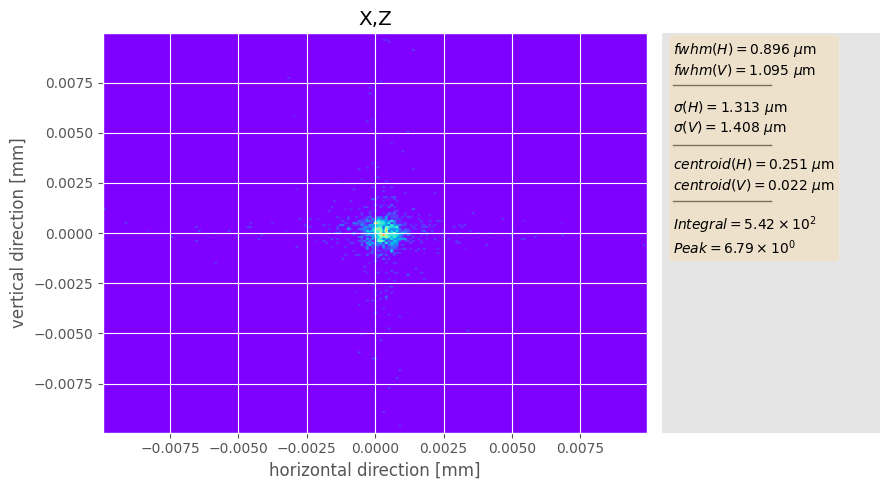

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.0005115143013307499, 0.0018934383459546034] 0.5459695289375367
BeamParameterOutput(parameter_value=0.0004866824537697203, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c035f8c10>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c2610ef70>, dw=<orangecont

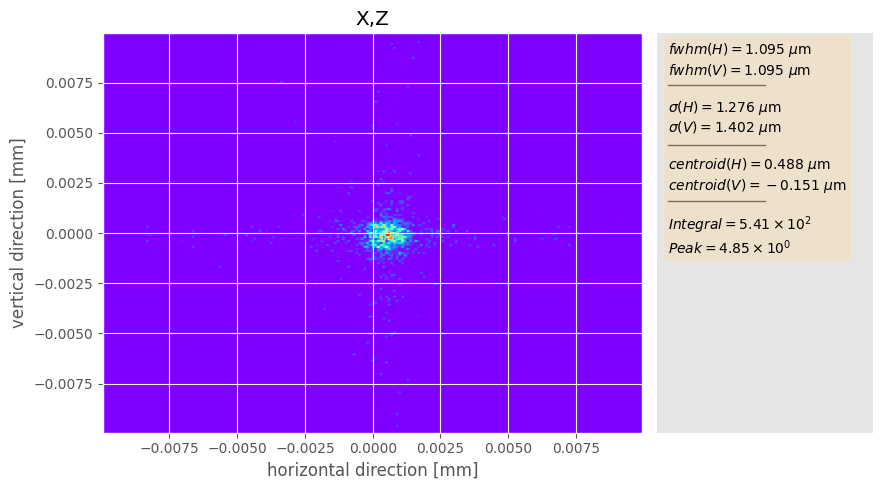

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.00016772160672599986, 0.0019509728625261918] 0.5533835145620818
BeamParameterOutput(parameter_value=0.0002135475125820749, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c11a74c70>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c036c6250>, dw=<orangecon

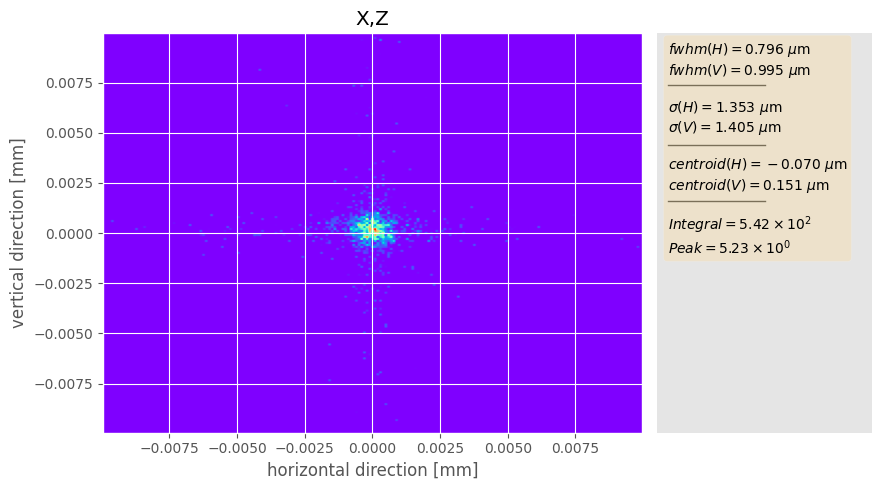

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[7.701227663551075e-05, 0.0019561659010259302] 0.555250996137794
BeamParameterOutput(parameter_value=0.00012547749343396153, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c027d4310>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c26439cd0>, dw=<orangecont

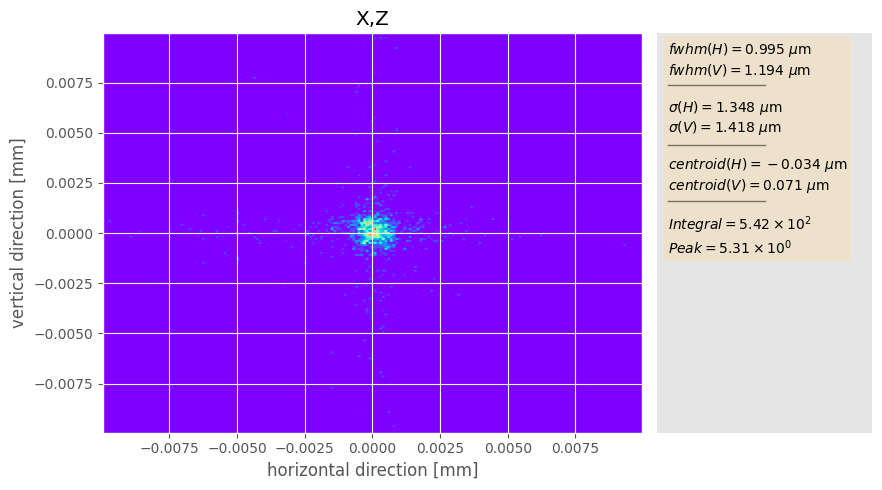

In [62]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [63]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

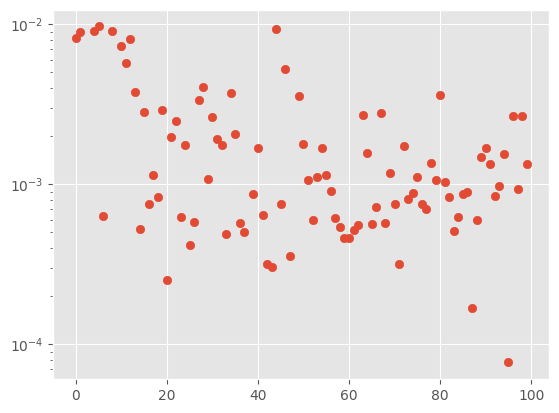

In [64]:
plt.scatter(tnums, centroids)
plt.yscale('log')

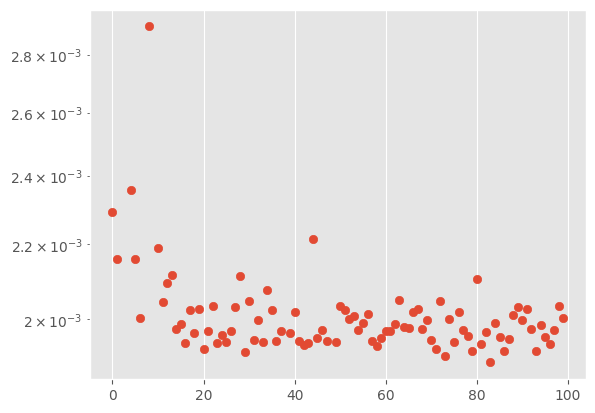

In [65]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

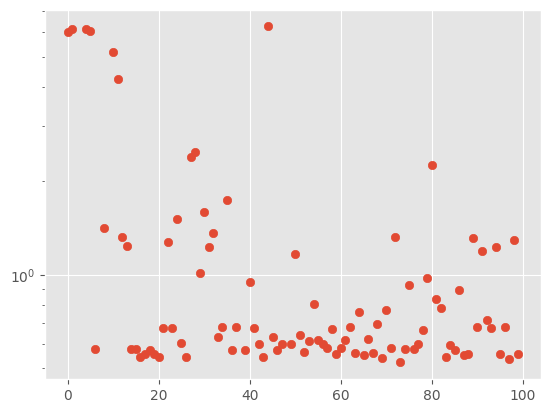

In [66]:
plt.scatter(tnums, wsums)
plt.yscale('log')

### Different starting structure + increased motor range

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


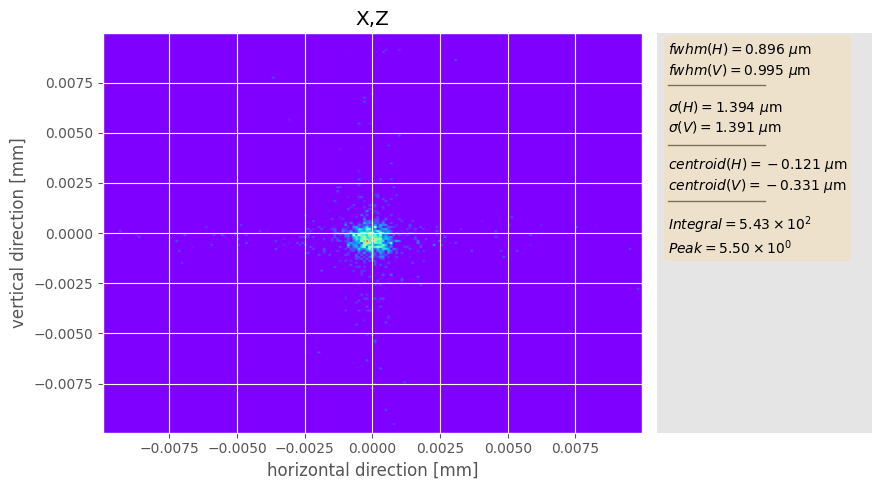

In [82]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [83]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.0003455714834023208, 0.002681373272666176)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4'] [-0.09722955499619701, -4.544531192786647, -2.422713780069692, 0.5998420087353509, -0.009777139868400257, 0.0071473859430290065, -3.7371457176589242, 4.048911852825842]


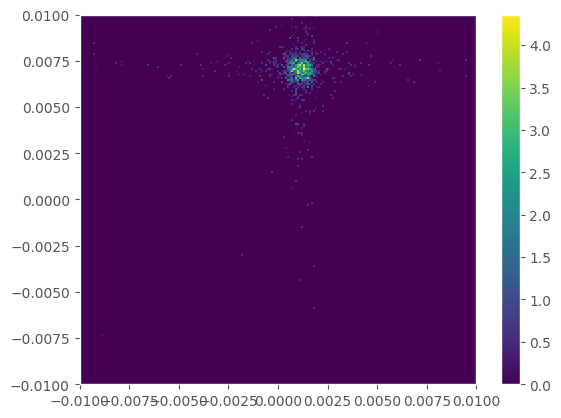

In [84]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [137]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
0.007104595555973813 0.0027347730136786834


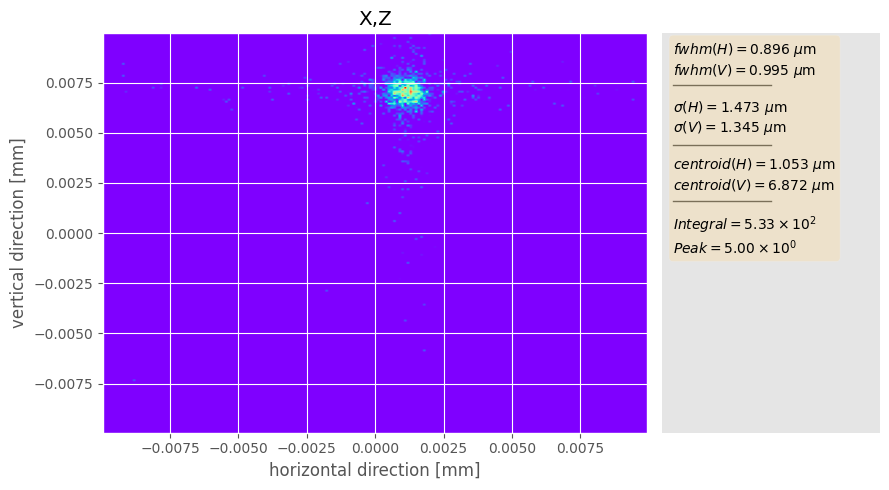

In [138]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [139]:
move_motors_ranges_2 = {k: np.array(v) * 2 for k, v in move_motors_ranges.items()}

In [140]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.01, 0.01],
                            camera_yrange=[-0.01, 0.01],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

opt_trial.reset()

In [141]:
base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-2e-3]}, seed=111)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/1022441631.py:1: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = BoTorchSampler(candidates_func=qnehvi_candidates_func, acq_func_kwargs={'ref_point':[-1e-3,-2e-3]}, seed=111)


In [142]:
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges_2.values()),
    integral_threshold=300,
    base_sampler=base_sampler,
    raise_prune_exception=True,
    use_discrete_space=True
)

[I 2022-10-17 14:23:43,207] A new study created in memory with name: no-name-32f61958-c0b4-46f4-b555-0cf81afb0bd4


In [143]:
opt_trial.trials(50, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/328431819.py:87: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

In [144]:
opt_trial.study.best_trials

[FrozenTrial(number=18, values=[0.0015413557279554666, 0.0018978156287052612], datetime_start=datetime.datetime(2022, 10, 17, 14, 24, 13, 523824), datetime_complete=datetime.datetime(2022, 10, 17, 14, 24, 16, 129326), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.0007500000000000007, 'vkb_3': 0.0045000000000000005, 'hkb_4': 2.0, 'vkb_4': -8.1}, distributions={'hkb_1': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'vkb_1': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'hkb_2': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'vkb_2': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'vkb_3': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'hkb_4': FloatDistribution(high=9.9, log=False, low=-10.0, step=0.1), 'vkb_4': FloatDistribution(high=9.9, log=False, low=-10.0, step=0.1)}, user_attr

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


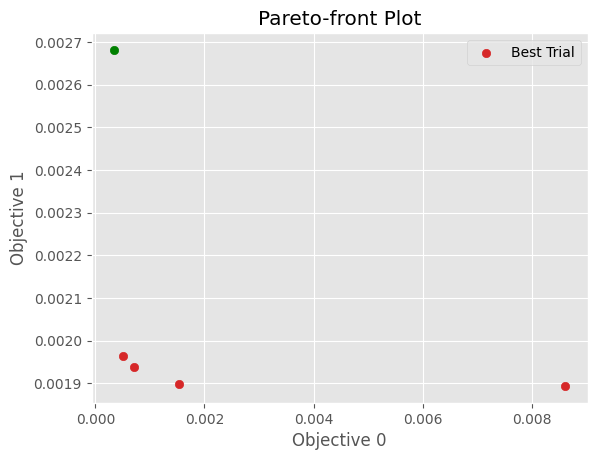

In [145]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [146]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-12.742144630291566 1.145972321623076
-11.02419469350613 6.222227080742476
-13.828183231257892 0.6952367973842749
-13.508200067713213 0.7351782411956534


[0.0015413557279554666, 0.0018978156287052612] 1.145972321623076


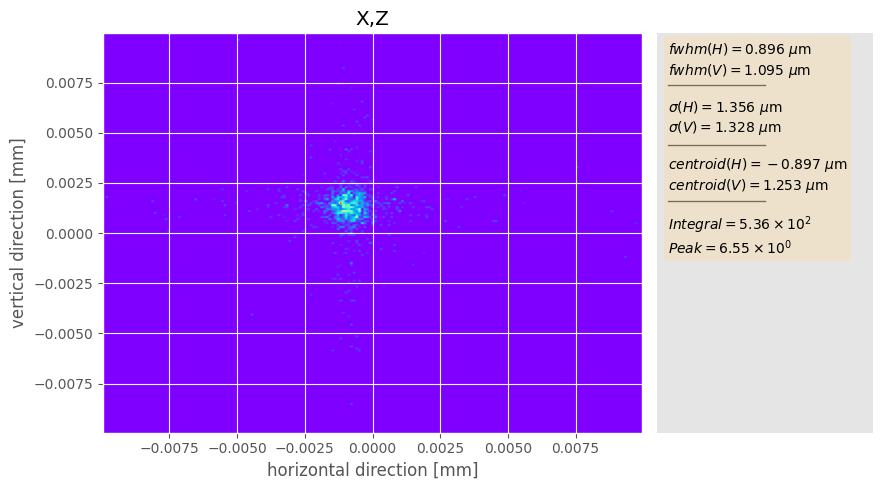

[0.008607211292131307, 0.0018940463949645465] 6.222227080742476


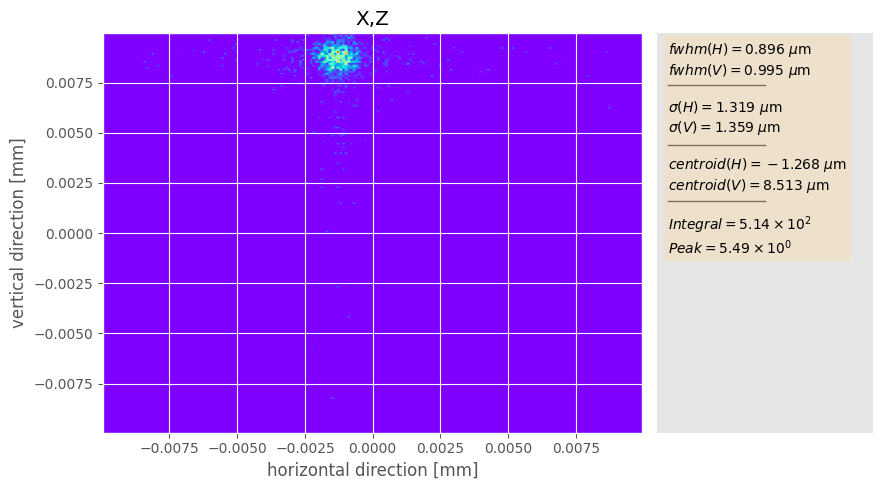

[0.0005028242323703352, 0.001963722556189626] 0.6952367973842749


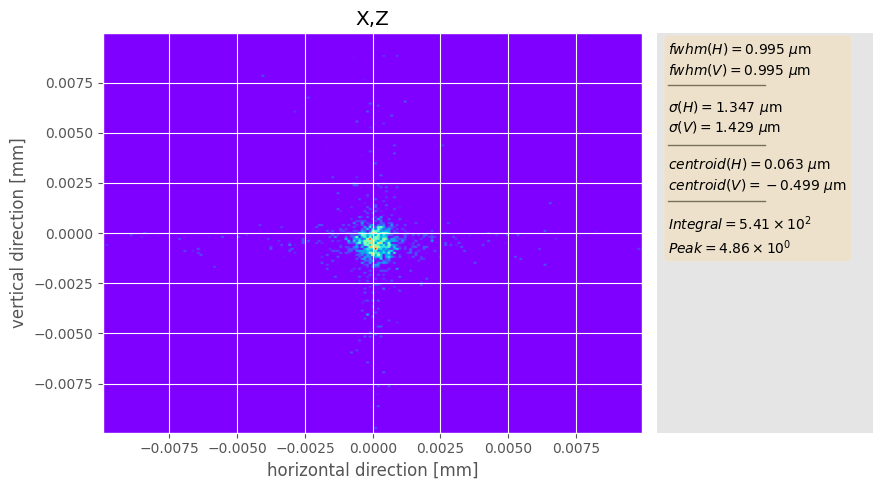

[0.0007010797045270557, 0.0019395271135934419] 0.7351782411956534


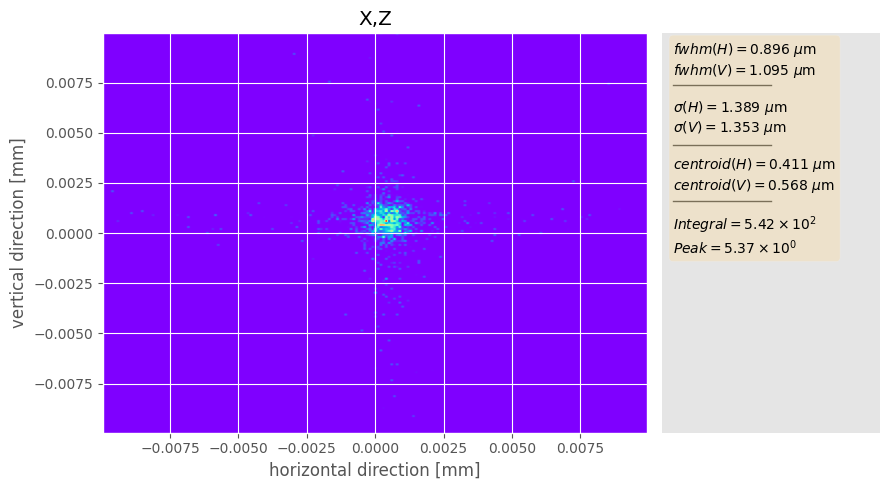

In [147]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [148]:
opt_trial.trials(50)

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:26:36,456] Trial 50 finished with values: [0.004919061554086757, 0.0020140684232787384] and parameters: {'hkb_1': 0.10660000000000025, 'vkb_1': 4.6012, 'hkb_2': -1.3331999999999997, 'vkb_2': 0.23430000000000106, 'hkb_3': -0.0007500000000000007, 'vkb_3': -0.006, 'hkb_4': 3.4000000000000004, 'vkb_4': -9.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:26:40,934] Trial 51 finished with values: [0.0018760981916161796, 0.0020008425523678893] and parameters: {'hkb_1': -2.7719999999999994, 'vkb_1': -1.4530999999999992, 'hkb_2': 2.6432, 'vkb_2': 0.9251000000000005, 'hkb_3': -0.0024999999999999988, 'vkb_3': -0.006, 'hkb_4': 2.200000000000001, 'vkb_4': -5.7}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:26:45,576] Trial 52 finished with values: [0.004952188827008838, 0.0019205033758544331] and parameters: {'hkb_1': -1.4771999999999998, 'vkb_1': 1.0299000000000014, 'hkb_2': -3.8041, 'vkb_2': 3.9023000000000003, 'hkb_3': 0.006249999999999999, 'vkb_3': 0.008, 'hkb_4': 3.1000000000000014, 'vkb_4': -6.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:26:49,711] Trial 53 finished with values: [0.001501218236969563, 0.0019389841346783032] and parameters: {'hkb_1': 1.0381, 'vkb_1': 5.5046, 'hkb_2': -0.21720000000000006, 'vkb_2': 2.5756000000000014, 'hkb_3': -0.00425, 'vkb_3': 0.002749999999999999, 'hkb_4': 0.8000000000000007, 'vkb_4': -7.1}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:26:54,005] Trial 54 finished with values: [0.0021422638552417933, 0.0020111599882599693] and parameters: {'hkb_1': -3.5558999999999994, 'vkb_1': 4.736500000000001, 'hkb_2': -1.8550000000000004, 'vkb_2': 4.333400000000001, 'hkb_3': -0.013000000000000001, 'vkb_3': -0.006, 'hkb_4': 0.3000000000000007, 'vkb_4': -4.699999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:26:58,217] Trial 55 finished with values: [0.0025349484344484507, 0.0019282997109810365] and parameters: {'hkb_1': -2.5706999999999995, 'vkb_1': 2.828900000000001, 'hkb_2': 3.5878000000000014, 'vkb_2': 6.328400000000002, 'hkb_3': -0.0024999999999999988, 'vkb_3': -0.00425, 'hkb_4': 1.1000000000000014, 'vkb_4': -2.8999999999999995}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:02,466] Trial 56 finished with values: [0.0013525545184356505, 0.0020096484934079236] and parameters: {'hkb_1': -4.5207, 'vkb_1': 1.000300000000001, 'hkb_2': -0.8064999999999998, 'vkb_2': -1.761899999999999, 'hkb_3': -0.0007500000000000007, 'vkb_3': -0.00425, 'hkb_4': 1.1000000000000014, 'vkb_4': -6.699999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:06,554] Trial 57 finished with values: [0.0031893167175725805, 0.0020024859180125063] and parameters: {'hkb_1': -3.9072999999999993, 'vkb_1': 6.423500000000001, 'hkb_2': -1.2011000000000003, 'vkb_2': 4.584300000000001, 'hkb_3': -0.006, 'vkb_3': -0.00425, 'hkb_4': 2.9000000000000004, 'vkb_4': -6.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:10,375] Trial 58 finished with values: [0.0035649406161014827, 0.0019442566953408991] and parameters: {'hkb_1': -5.1448, 'vkb_1': 2.3360000000000003, 'hkb_2': 3.6554, 'vkb_2': 3.3825000000000003, 'hkb_3': 0.015000000000000003, 'vkb_3': 0.006249999999999999, 'hkb_4': 6.699999999999999, 'vkb_4': -7.1}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:14,230] Trial 59 finished with values: [0.004024774068976479, 0.0019559692597422135] and parameters: {'hkb_1': -2.6517, 'vkb_1': 2.6289, 'hkb_2': 2.368500000000001, 'vkb_2': 1.8725000000000005, 'hkb_3': 0.002749999999999999, 'vkb_3': -0.00425, 'hkb_4': 2.5, 'vkb_4': -1.299999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:18,936] Trial 60 finished with values: [0.005504808495260517, 0.0019429841218392033] and parameters: {'hkb_1': -2.8172999999999995, 'vkb_1': 6.962, 'hkb_2': 0.8166000000000011, 'vkb_2': 1.988100000000001, 'hkb_3': 0.008, 'vkb_3': 0.0115, 'hkb_4': 5.0, 'vkb_4': -7.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:23,244] Trial 61 finished with values: [0.0009973651658687916, 0.0020111395493647784] and parameters: {'hkb_1': -8.1255, 'vkb_1': -6.3283000000000005, 'hkb_2': 0.3244000000000007, 'vkb_2': 8.6888, 'hkb_3': -0.0024999999999999988, 'vkb_3': -0.00425, 'hkb_4': 1.0, 'vkb_4': -6.6}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:27,368] Trial 62 finished with values: [0.0029532430763130023, 0.0020092548948765837] and parameters: {'hkb_1': -5.9378, 'vkb_1': -4.1144, 'hkb_2': -2.7493, 'vkb_2': 1.9998000000000005, 'hkb_3': -0.00425, 'vkb_3': 0.0010000000000000009, 'hkb_4': 0.0, 'vkb_4': -4.8999999999999995}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:31,222] Trial 63 finished with values: [0.0014536336758979149, 0.002042746042313376] and parameters: {'hkb_1': -7.0516, 'vkb_1': -2.7154999999999996, 'hkb_2': -1.1691000000000003, 'vkb_2': 5.3801000000000005, 'hkb_3': -0.00425, 'vkb_3': -0.006, 'hkb_4': 1.700000000000001, 'vkb_4': -4.6}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:34,927] Trial 64 finished with values: [0.0003698684863719878, 0.001958916960521666] and parameters: {'hkb_1': -9.5626, 'vkb_1': -2.7215, 'hkb_2': 6.639800000000001, 'vkb_2': 9.5728, 'hkb_3': -0.0007500000000000007, 'vkb_3': -0.00425, 'hkb_4': 0.6000000000000014, 'vkb_4': -5.3999999999999995}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:39,064] Trial 65 finished with values: [0.0008046959341833225, 0.0018757212131709166] and parameters: {'hkb_1': -9.9562, 'vkb_1': -0.5472000000000001, 'hkb_2': 1.5144000000000002, 'vkb_2': 6.5976, 'hkb_3': -0.01125, 'vkb_3': -0.0007500000000000007, 'hkb_4': -1.4000000000000004, 'vkb_4': -6.3}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:43,802] Trial 66 finished with values: [0.004191699009630713, 0.0020708866961986856] and parameters: {'hkb_1': -9.9014, 'vkb_1': -2.4445999999999994, 'hkb_2': -0.6952999999999996, 'vkb_2': 6.756800000000002, 'hkb_3': -0.01475, 'vkb_3': 0.009750000000000002, 'hkb_4': 0.6000000000000014, 'vkb_4': -8.9}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:47,849] Trial 67 finished with values: [0.00219099045316979, 0.0021091742101486547] and parameters: {'hkb_1': -9.4855, 'vkb_1': -4.6567, 'hkb_2': 2.8484, 'vkb_2': 9.189400000000003, 'hkb_3': -0.0024999999999999988, 'vkb_3': -0.0024999999999999988, 'hkb_4': -1.799999999999999, 'vkb_4': -6.4}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:52,320] Trial 68 finished with values: [0.006282812906588006, 0.002033365630456657] and parameters: {'hkb_1': -9.6749, 'vkb_1': 0.061500000000000554, 'hkb_2': 7.472100000000001, 'vkb_2': 2.8025, 'hkb_3': 0.013250000000000001, 'vkb_3': 0.015000000000000003, 'hkb_4': 2.8000000000000007, 'vkb_4': -8.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:27:57,212] Trial 69 finished with values: [0.007964650149977243, 0.0019079765695638302] and parameters: {'hkb_1': -4.9559, 'vkb_1': 4.642900000000001, 'hkb_2': 5.093500000000001, 'vkb_2': 7.103300000000001, 'hkb_3': -0.0165, 'vkb_3': 0.013250000000000001, 'hkb_4': -0.5, 'vkb_4': -5.7}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:02,524] Trial 70 finished with values: [0.0012023233349681825, 0.0021839176354891943] and parameters: {'hkb_1': -9.9456, 'vkb_1': 3.533800000000001, 'hkb_2': 5.809200000000001, 'vkb_2': 8.6704, 'hkb_3': -0.01475, 'vkb_3': 0.0010000000000000009, 'hkb_4': -1.4000000000000004, 'vkb_4': -8.6}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:06,460] Trial 71 finished with values: [0.0009354160582530401, 0.0020789398025821203] and parameters: {'hkb_1': -0.17849999999999966, 'vkb_1': -1.142199999999999, 'hkb_2': 6.821999999999999, 'vkb_2': 7.3765, 'hkb_3': 0.002749999999999999, 'vkb_3': 0.002749999999999999, 'hkb_4': 1.9000000000000004, 'vkb_4': -9.7}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:11,565] Trial 72 finished with values: [0.001437967612733925, 0.0019788307246243974] and parameters: {'hkb_1': -7.3467, 'vkb_1': 4.605700000000001, 'hkb_2': 7.095200000000002, 'vkb_2': 9.8413, 'hkb_3': -0.0095, 'vkb_3': -0.00425, 'hkb_4': 0.0, 'vkb_4': -6.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:16,174] Trial 73 finished with values: [0.000245141414539978, 0.0020509949285267273] and parameters: {'hkb_1': -9.3575, 'vkb_1': 7.209800000000001, 'hkb_2': 8.9041, 'vkb_2': 7.270300000000002, 'hkb_3': -0.0007500000000000007, 'vkb_3': 0.002749999999999999, 'hkb_4': 1.1000000000000014, 'vkb_4': -8.7}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:20,348] Trial 74 finished with values: [0.0014120588524685377, 0.0019282893045442855] and parameters: {'hkb_1': 2.5355000000000008, 'vkb_1': 2.5898000000000003, 'hkb_2': 8.2365, 'vkb_2': 6.7623999999999995, 'hkb_3': 0.013250000000000001, 'vkb_3': -0.00425, 'hkb_4': 3.1000000000000014, 'vkb_4': -6.1}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:24,270] Trial 75 finished with values: [0.001462747561711213, 0.002062108067729626] and parameters: {'hkb_1': 2.762600000000001, 'vkb_1': 9.586400000000001, 'hkb_2': 8.3144, 'vkb_2': 0.9659000000000013, 'hkb_3': 0.0185, 'vkb_3': 0.0045000000000000005, 'hkb_4': 7.199999999999999, 'vkb_4': -9.4}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:28,338] Trial 76 finished with values: [0.0030669747356419845, 0.0019825533442262818] and parameters: {'hkb_1': 8.7133, 'vkb_1': 1.5822000000000003, 'hkb_2': 9.938100000000002, 'vkb_2': 7.8095, 'hkb_3': 0.009750000000000002, 'vkb_3': 0.0010000000000000009, 'hkb_4': 6.400000000000002, 'vkb_4': -6.3}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:32,280] Trial 77 finished with values: [0.0022641663720295952, 0.0019762367505643348] and parameters: {'hkb_1': -3.6162, 'vkb_1': 5.614600000000001, 'hkb_2': 5.048, 'vkb_2': 6.448700000000002, 'hkb_3': 0.0045000000000000005, 'vkb_3': -0.0024999999999999988, 'hkb_4': 2.0, 'vkb_4': -8.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:36,899] Trial 78 finished with values: [0.0036008811413184186, 0.00196359833216235] and parameters: {'hkb_1': -5.1068, 'vkb_1': 4.9483000000000015, 'hkb_2': 7.738500000000002, 'vkb_2': 8.107100000000003, 'hkb_3': 0.015000000000000003, 'vkb_3': 0.008, 'hkb_4': 4.5, 'vkb_4': -7.4}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:41,721] Trial 79 finished with values: [0.005656290708659919, 0.002006492761324736] and parameters: {'hkb_1': 5.604700000000001, 'vkb_1': 3.7966000000000015, 'hkb_2': 5.924200000000001, 'vkb_2': 6.878299999999999, 'hkb_3': 0.015000000000000003, 'vkb_3': 0.0115, 'hkb_4': 4.800000000000001, 'vkb_4': -6.9}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:46,875] Trial 80 finished with values: [0.0039720968364643046, 0.0020759534244846156] and parameters: {'hkb_1': -3.5511999999999997, 'vkb_1': 4.0709, 'hkb_2': 7.880800000000001, 'vkb_2': 5.8530000000000015, 'hkb_3': -0.00425, 'vkb_3': 0.0010000000000000009, 'hkb_4': 2.0, 'vkb_4': -4.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:51,010] Trial 81 finished with values: [0.0006499709136877691, 0.002012452317645327] and parameters: {'hkb_1': 8.7423, 'vkb_1': 6.317500000000003, 'hkb_2': 8.839100000000002, 'vkb_2': 6.999700000000001, 'hkb_3': 0.008, 'vkb_3': -0.00775, 'hkb_4': 3.6000000000000014, 'vkb_4': -4.3}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:55,462] Trial 82 finished with values: [0.003946730234325403, 0.0021154905464776217] and parameters: {'hkb_1': -9.6639, 'vkb_1': 6.5898, 'hkb_2': -2.0554999999999994, 'vkb_2': 2.5375000000000014, 'hkb_3': 0.013250000000000001, 'vkb_3': -0.0024999999999999988, 'hkb_4': 0.40000000000000036, 'vkb_4': -6.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:28:59,828] Trial 83 finished with values: [0.0015575244917598666, 0.001968396058711617] and parameters: {'hkb_1': 5.9780000000000015, 'vkb_1': 8.726300000000002, 'hkb_2': -6.0645, 'vkb_2': -1.184899999999999, 'hkb_3': -0.0024999999999999988, 'vkb_3': -0.0007500000000000007, 'hkb_4': 2.3000000000000007, 'vkb_4': -6.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:04,579] Trial 84 finished with values: [0.0022144247393297662, 0.0023099168337098654] and parameters: {'hkb_1': -7.6483, 'vkb_1': 0.4892000000000003, 'hkb_2': 4.200900000000001, 'vkb_2': 7.371000000000002, 'hkb_3': 0.006249999999999999, 'vkb_3': 0.0045000000000000005, 'hkb_4': 0.40000000000000036, 'vkb_4': -10.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:09,056] Trial 85 finished with values: [0.0029074327994599, 0.002019102214993489] and parameters: {'hkb_1': 8.9697, 'vkb_1': -1.586599999999999, 'hkb_2': -1.1113999999999997, 'vkb_2': 9.630000000000003, 'hkb_3': 0.0115, 'vkb_3': -0.00425, 'hkb_4': 1.4000000000000004, 'vkb_4': -4.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:14,008] Trial 86 finished with values: [0.0007848387906194823, 0.0019538073071661407] and parameters: {'hkb_1': 5.1874, 'vkb_1': 5.857800000000001, 'hkb_2': -1.7036999999999995, 'vkb_2': 8.1252, 'hkb_3': 0.006249999999999999, 'vkb_3': -0.0024999999999999988, 'hkb_4': 3.3000000000000007, 'vkb_4': -6.9}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:19,562] Trial 87 finished with values: [0.002382078383412222, 0.002142742177701608] and parameters: {'hkb_1': 6.318200000000001, 'vkb_1': 8.921400000000002, 'hkb_2': 7.0382, 'vkb_2': 3.6191000000000013, 'hkb_3': 0.013250000000000001, 'vkb_3': 0.0010000000000000009, 'hkb_4': 3.200000000000001, 'vkb_4': -9.8}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:25,159] Trial 88 finished with values: [0.0005302884359025875, 0.002009991285192474] and parameters: {'hkb_1': -1.5787999999999993, 'vkb_1': -5.2631, 'hkb_2': 9.808, 'vkb_2': 6.560200000000002, 'hkb_3': 0.0010000000000000009, 'vkb_3': 0.0010000000000000009, 'hkb_4': 1.1000000000000014, 'vkb_4': -8.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:29,553] Trial 89 finished with values: [0.0006796599333481968, 0.002014104333194835] and parameters: {'hkb_1': 5.755600000000001, 'vkb_1': 3.8694000000000006, 'hkb_2': 2.1654999999999998, 'vkb_2': 3.2591, 'hkb_3': 0.009750000000000002, 'vkb_3': -0.006, 'hkb_4': 4.300000000000001, 'vkb_4': -4.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:34,331] Trial 90 finished with values: [0.00272545598461719, 0.0021211317830857755] and parameters: {'hkb_1': 2.0036000000000005, 'vkb_1': 7.569400000000002, 'hkb_2': -3.5747, 'vkb_2': 9.7134, 'hkb_3': 0.009750000000000002, 'vkb_3': 0.0010000000000000009, 'hkb_4': 6.5, 'vkb_4': -7.699999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:40,052] Trial 91 finished with values: [0.0017857757202482437, 0.0019317670076130992] and parameters: {'hkb_1': 1.4905000000000008, 'vkb_1': -2.0048999999999992, 'hkb_2': 2.8262, 'vkb_2': 8.3138, 'hkb_3': -0.0024999999999999988, 'vkb_3': 0.0010000000000000009, 'hkb_4': 0.20000000000000107, 'vkb_4': -6.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:45,598] Trial 92 finished with values: [0.0019995883769804244, 0.00199183938435569] and parameters: {'hkb_1': -9.2503, 'vkb_1': -6.6305, 'hkb_2': 7.290700000000001, 'vkb_2': 9.8601, 'hkb_3': 0.008, 'vkb_3': -0.00425, 'hkb_4': 4.9, 'vkb_4': -5.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:51,261] Trial 93 finished with values: [0.0013147366957560423, 0.001954015546381203] and parameters: {'hkb_1': 2.4826000000000015, 'vkb_1': -8.3149, 'hkb_2': 5.8443000000000005, 'vkb_2': 9.2839, 'hkb_3': 0.0045000000000000005, 'vkb_3': -0.013000000000000001, 'hkb_4': 2.0, 'vkb_4': -3.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:29:57,458] Trial 94 finished with values: [0.0031705643472043138, 0.0020572985223830703] and parameters: {'hkb_1': 9.9524, 'vkb_1': -2.9986999999999995, 'hkb_2': 0.35219999999999985, 'vkb_2': 8.615400000000001, 'hkb_3': 0.002749999999999999, 'vkb_3': -0.0095, 'hkb_4': 4.800000000000001, 'vkb_4': -5.0}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:30:03,596] Trial 95 finished with values: [0.0017065234192460068, 0.0019137115712292902] and parameters: {'hkb_1': 8.7943, 'vkb_1': 4.742800000000001, 'hkb_2': -8.483, 'vkb_2': -3.2033999999999994, 'hkb_3': 0.0115, 'vkb_3': -0.0024999999999999988, 'hkb_4': 3.4000000000000004, 'vkb_4': -7.5}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:30:08,783] Trial 96 finished with values: [0.0024773123727195464, 0.0020760559270379167] and parameters: {'hkb_1': 8.067700000000002, 'vkb_1': -0.5086999999999993, 'hkb_2': 5.5112000000000005, 'vkb_2': 7.745799999999999, 'hkb_3': 0.016749999999999998, 'vkb_3': -0.0095, 'hkb_4': 2.8000000000000007, 'vkb_4': -3.3}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:30:14,018] Trial 97 finished with values: [0.005605276483574178, 0.0021231953962047574] and parameters: {'hkb_1': 3.586500000000001, 'vkb_1': 8.322300000000002, 'hkb_2': -9.0864, 'vkb_2': -4.9822999999999995, 'hkb_3': 0.015000000000000003, 'vkb_3': 0.006249999999999999, 'hkb_4': 2.3000000000000007, 'vkb_4': -4.8999999999999995}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:30:19,525] Trial 98 finished with values: [0.0013461632050245542, 0.0019225392346308974] and parameters: {'hkb_1': 7.717300000000002, 'vkb_1': 3.3453, 'hkb_2': -6.1028, 'vkb_2': 2.6426, 'hkb_3': 0.0045000000000000005, 'vkb_3': -0.0024999999999999988, 'hkb_4': 1.6000000000000014, 'vkb_4': -5.199999999999999}. 
/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test/test_optuna_qnehvi.py:552: ExperimentalWarning: qnehvi_candidates_func is experimental (supported from v2.4.0). The interface can change in the future.
  candidates = self._candidates_func(params, values, con, bounds, self._acq_func_kwargs)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-10, 9.900000000000002] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-10, 9.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-10-17 14:30:24,816] Trial 99 finished with values: [0.001277666490861118, 0.0020032063866514582] and parameters: {'hkb_1': 9.214400000000001, 'vkb_1': -6.634399999999999, 'hkb_2': 8.462600000000002, 'vkb_2': 5.280100000000001, 'hkb_3': 0.0115, 'vkb_3': -0.006, 'hkb_4': 3.6000000000000014, 'vkb_4': -6.0}. 


In [149]:
opt_trial.study.best_trials

[FrozenTrial(number=40, values=[0.0007010797045270557, 0.0019395271135934419], datetime_start=datetime.datetime(2022, 10, 17, 14, 25, 17, 89605), datetime_complete=datetime.datetime(2022, 10, 17, 14, 25, 20, 492436), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0010000000000000009, 'vkb_3': -0.0007500000000000007, 'hkb_4': 1.1000000000000014, 'vkb_4': -6.4}, distributions={'hkb_1': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'vkb_1': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'hkb_2': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'vkb_2': FloatDistribution(high=9.9999, log=False, low=-10.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'vkb_3': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'hkb_4': FloatDistribution(high=9.9, log=False, low=-10.0, step=0.1), 'vkb_4': FloatDistribution(high=9.9, log=False, low=-10.0, step=0.

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_72464/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


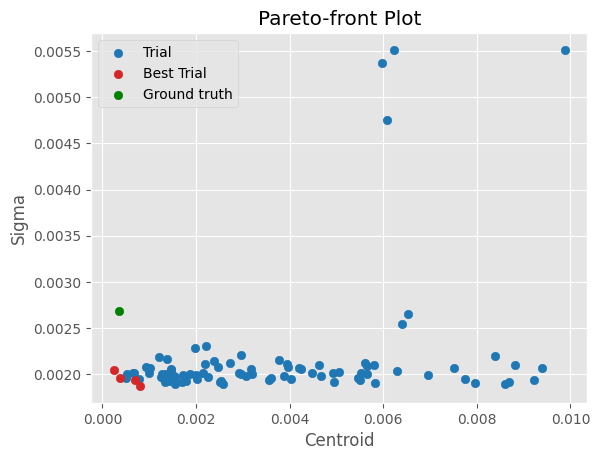

In [150]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [151]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.508200067713213
-14.137726587374274
-13.403808119904827
-14.503105584310841


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.0007010797045270557, 0.0019395271135934419] 0.7351782411956534
BeamParameterOutput(parameter_value=0.0007074643097372695, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c0778b1c0>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7b915df8e0>, dw=<orangecont

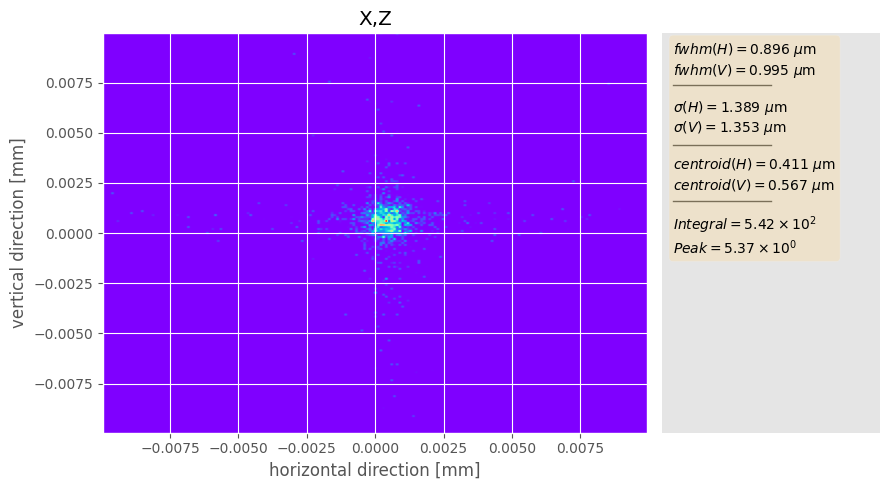

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.0003698684863719878, 0.001958916960521666] 0.5538842449649961
BeamParameterOutput(parameter_value=0.00033050462509392076, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c1226bdc0>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7ba0e62760>, dw=<orangecont

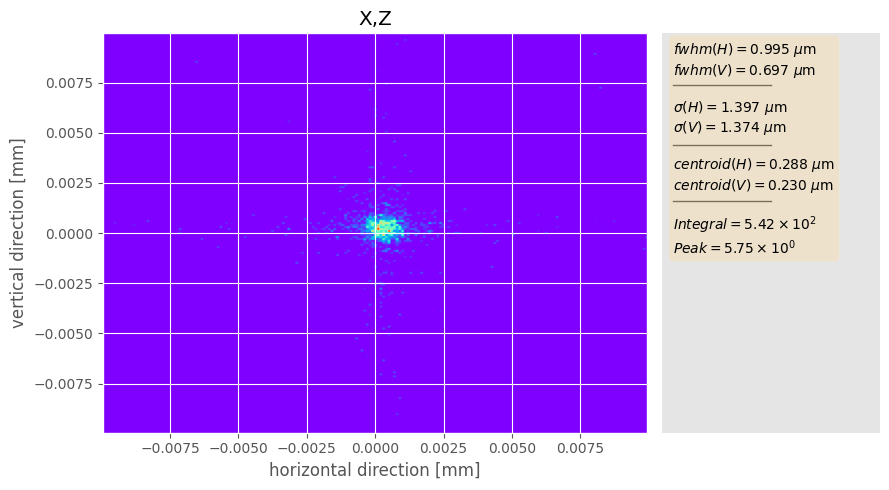

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.0008046959341833225, 0.0018757212131709166] 0.8499720975835857
BeamParameterOutput(parameter_value=0.0008337943221127802, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7c26b14340>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c076cad00>, dw=<orangecont

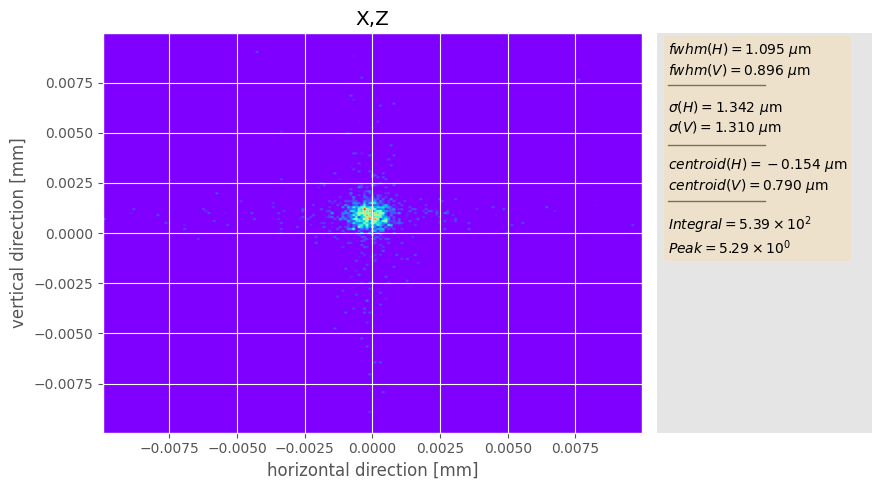

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-41872/Downstream_HKB_bender_profile.dat written to disk.
[0.000245141414539978, 0.0020509949285267273] 0.5628186410833381
BeamParameterOutput(parameter_value=0.00030337283394568534, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f7b90576220>, hist=<aps_ai.common.util.common.Histogram object at 0x7f7c139fa6d0>, dw=<orangecont

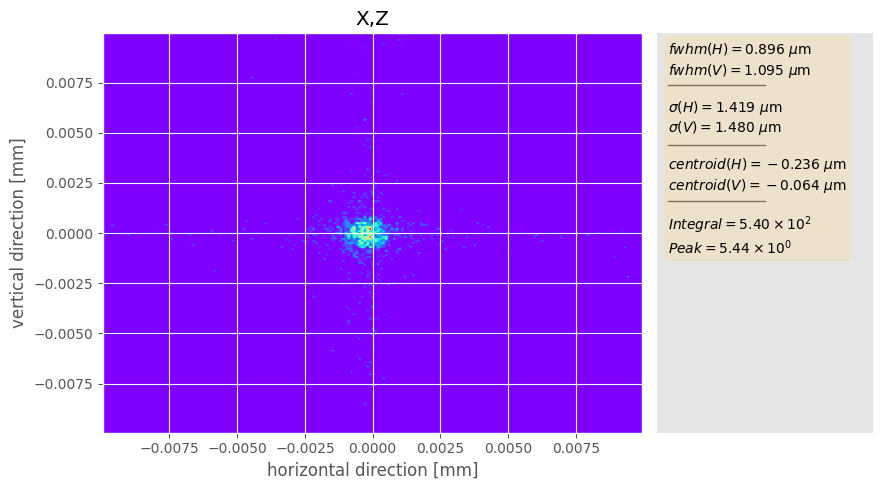

In [158]:
best_absolute_positions = []
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    pos_this = movers.get_absolute_positions(focusing_system, opt_trial.motor_types)
    best_absolute_positions.append(pos_this)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [153]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

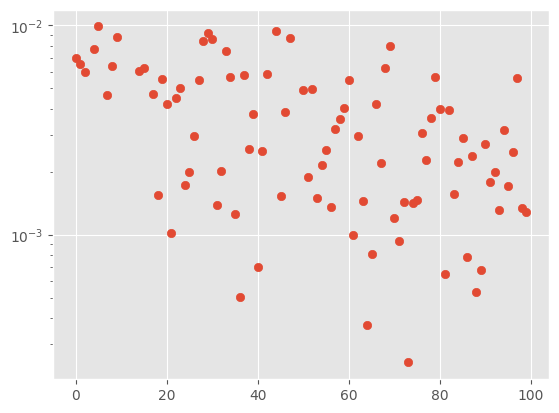

In [154]:
plt.scatter(tnums, centroids)
plt.yscale('log')

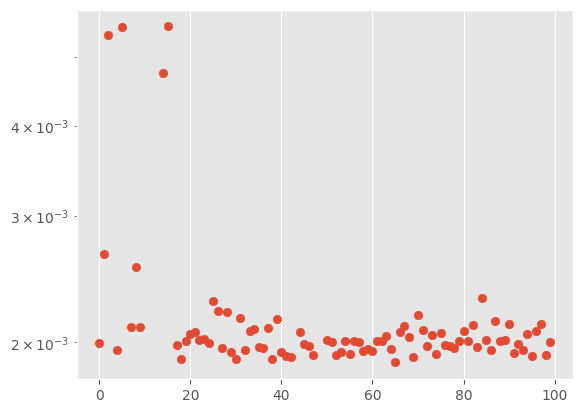

In [155]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

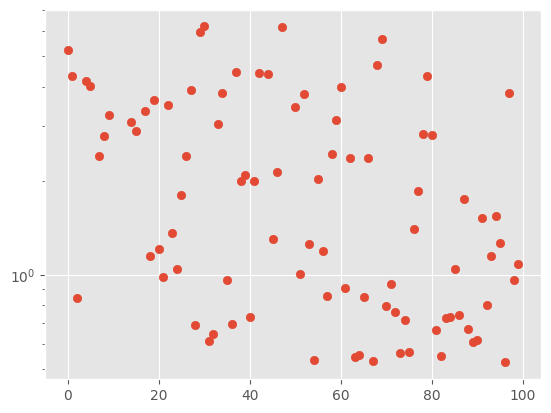

In [156]:
plt.scatter(tnums, wsums)
plt.yscale('log')

In [157]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])

In [160]:
np.round(best_absolute_positions, 2)

array([[215.4 , 139.46, 110.08, 232.1 ,   2.99,   3.01,  -2.54,  -2.5 ],
       [205.84, 136.73, 116.72, 241.67,   2.99,   3.  ,  -3.04,  -1.5 ],
       [205.45, 138.91, 111.59, 238.7 ,   2.98,   3.01,  -5.05,  -2.4 ],
       [206.05, 146.67, 118.98, 239.37,   2.99,   3.01,  -2.54,  -4.8 ]])